# Task 2 Clustering


In [90]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, FastICA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

We upload the dataset obtained after the data preparation phase.

In [91]:
df_incidents = pd.read_csv('../dataset_preparation/incidents_prepared.csv', sep=',', index_col=0)

df_incidents.info()

<class 'pandas.core.frame.DataFrame'>
Index: 161550 entries, 0 to 164506
Data columns (total 32 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   date                       161550 non-null  object 
 1   state                      161550 non-null  object 
 2   city_or_county             161550 non-null  object 
 3   address                    149848 non-null  object 
 4   latitude                   161550 non-null  float64
 5   longitude                  161550 non-null  float64
 6   congressional_district     161550 non-null  float64
 7   avg_age_participants       161550 non-null  float64
 8   n_killed                   161550 non-null  int64  
 9   incident_characteristics1  161550 non-null  object 
 10  year                       161550 non-null  float64
 11  age_group                  161550 non-null  object 
 12  povertyPercentage          161550 non-null  float64
 13  population                 161550 

## Selecting useful features for clustering
Now, we can select the most useful features for clustering. The selection is based on the correlation matrix, seen in the data preparation.
From the original dataset, we selected only the feature `avg_age_participants`.
We then use the features and indicators defined by us: `severity`, `severity_minor`, `killed_by_district`, `injured_by_district`, `povertyPercentage`, `arrested_ratio`, `unharmed_ratio`, `right_or_left`.

In [92]:
df_incidents.columns

Index(['date', 'state', 'city_or_county', 'address', 'latitude', 'longitude',
       'congressional_district', 'avg_age_participants', 'n_killed',
       'incident_characteristics1', 'year', 'age_group', 'povertyPercentage',
       'population', 'party', 'candidatevotes', 'severity', 'severity_cat',
       'severity_minor', 'year_month', 'killed_by_district',
       'injured_by_district', 'arrested_ratio', 'unharmed_ratio',
       'right_or_left', 'dfm_district_killed', 'dfm_district_injured',
       'dfm_district_participants', 'dfm_district_child', 'dfm_district_teen',
       'dfm_district_females', 'voters_over_population'],
      dtype='object')

In [93]:
cols_for_clustering =['avg_age_participants', 'povertyPercentage',
        'severity', 'severity_minor', 'killed_by_district',
       'injured_by_district', 'arrested_ratio', 'unharmed_ratio',
       'right_or_left']

In [94]:
# drop the columns that we don't need
df_incidents_clustering = df_incidents[cols_for_clustering]
df_incidents_clustering.info()

<class 'pandas.core.frame.DataFrame'>
Index: 161550 entries, 0 to 164506
Data columns (total 9 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   avg_age_participants  161550 non-null  float64
 1   povertyPercentage     161550 non-null  float64
 2   severity              161550 non-null  float64
 3   severity_minor        161550 non-null  float64
 4   killed_by_district    161550 non-null  float64
 5   injured_by_district   161550 non-null  float64
 6   arrested_ratio        161550 non-null  float64
 7   unharmed_ratio        161550 non-null  float64
 8   right_or_left         161550 non-null  float64
dtypes: float64(9)
memory usage: 12.3 MB


In [95]:
#entropy of each feature
from scipy.stats import entropy
for col in df_incidents_clustering.columns:
    print(col, entropy(df_incidents_clustering[col].value_counts(normalize=True)))

avg_age_participants 3.7726645408807515
povertyPercentage 4.18758888580303
severity 1.795126453848965
severity_minor 0.6260837228952216
killed_by_district 1.4039374353167249
injured_by_district 2.454894647628055
arrested_ratio 1.1864229069442342
unharmed_ratio 1.0220789597622542
right_or_left 6.495060360654568


In [96]:
# we drop the rows with nan
df_incidents_clustering = df_incidents_clustering.dropna()

## Scaling and PCA

We proceed with the scaling in order to have mean 0 and variance 1 for all the attributes.

In [97]:
scaler = StandardScaler()
df_incidents_scaled = scaler.fit_transform(df_incidents_clustering)
df_incidents_scaled = pd.DataFrame(df_incidents_scaled, columns=df_incidents_clustering.columns)
df_incidents_scaled.describe()

avg_age_participants  povertyPercentage      severity  severity_minor  \
count          1.615500e+05       1.615500e+05  1.615500e+05    1.615500e+05   
mean          -1.843761e-16      -2.075990e-16  1.600975e-16    2.199142e-17   
std            1.000003e+00       1.000003e+00  1.000003e+00    1.000003e+00   
min           -2.419643e+00      -2.617057e+00 -1.086602e+00   -3.248521e-01   
25%           -7.315237e-01      -6.516270e-01 -1.086602e+00   -3.248521e-01   
50%           -2.492038e-01      -1.056741e-01  1.059600e-01   -3.248521e-01   
75%            4.742761e-01       5.494693e-01  3.047203e-01   -3.248521e-01   
max            5.297475e+00       3.352027e+00  1.696042e+00    6.710766e+00   

       killed_by_district  injured_by_district  arrested_ratio  \
count        1.615500e+05         1.615500e+05    1.615500e+05   
mean         5.629803e-18        -5.629803e-18   -1.104849e-16   
std          1.000003e+00         1.000003e+00    1.000003e+00   
min         -4.436121e-01        -4.939728e-01   -7.317171e-01   
25%         -4.436121e-01        -4.939728e-01   -7.317171e-01   
50%         -4.436121e-01        -4.939728e-01   -7.317171e-01   
75%         -6.380239e-02         3.729213e-02    5.023855e-01   
max          4.114105e+00         4.287412e+00    1.736488e+00   

       unharmed_ratio  right_or_left  
count    1.615500e+05   1.615500e+05  
mean     1.238557e-16   3.856415e-16  
std      1.000003e+00   1.000003e+00  
min     -5.689729e-01  -2.083602e+00  
25%     -5.689729e-01  -8.098118e-01  
50%     -5.689729e-01  -1.053906e-01  
75%      6.680416e-01   7.901994e-01  
max      2.523563e+00   2.630336e+00

In [98]:
df_incidents_scaled.head()

avg_age_participants  povertyPercentage  severity  severity_minor  \
0             -0.892297          -0.105674  0.105960       -0.324852   
1              0.152729          -0.105674  1.696042       -0.324852   
2              0.474276          -0.105674  1.696042       -0.324852   
3             -0.972684          -0.105674  1.696042       -0.324852   
4              1.840849          -0.105674  0.105960       -0.324852   

   killed_by_district  injured_by_district  arrested_ratio  unharmed_ratio  \
0           -0.443612             0.701373       -0.731717       -0.568973   
1            1.075627            -0.493973        0.502386       -0.568973   
2            1.075627            -0.493973        0.502386       -0.568973   
3            1.075627            -0.493973       -0.731717       -0.568973   
4           -0.443612             0.701373       -0.731717       -0.568973   

   right_or_left  
0        0.05029  
1        0.05029  
2        0.05029  
3        0.05029  
4        0.05029

We also use the MinMaxScaler, which scales the data in the range [0,1].

In [99]:
scaler_mm = MinMaxScaler()
df_incidents_scaled_mm = scaler_mm.fit_transform(df_incidents_clustering)
df_incidents_scaled_mm = pd.DataFrame(df_incidents_scaled_mm, columns=df_incidents_clustering.columns)
df_incidents_scaled_mm.describe()

avg_age_participants  povertyPercentage       severity  severity_minor  \
count         161550.000000      161550.000000  161550.000000   161550.000000   
mean               0.313542           0.438435       0.390493        0.046173   
std                0.129582           0.167530       0.359372        0.142134   
min                0.000000           0.000000       0.000000        0.000000   
25%                0.218750           0.329268       0.000000        0.000000   
50%                0.281250           0.420732       0.428571        0.000000   
75%                0.375000           0.530488       0.500000        0.000000   
max                1.000000           1.000000       1.000000        1.000000   

       killed_by_district  injured_by_district  arrested_ratio  \
count       161550.000000        161550.000000   161550.000000   
mean             0.097332             0.103312        0.296457   
std              0.219409             0.209145        0.405154   
min              0.000000             0.000000        0.000000   
25%              0.000000             0.000000        0.000000   
50%              0.000000             0.000000        0.000000   
75%              0.083333             0.111111        0.500000   
max              1.000000             1.000000        1.000000   

       unharmed_ratio  right_or_left  
count   161550.000000  161550.000000  
mean         0.183983       0.442009  
std          0.323360       0.212138  
min          0.000000       0.000000  
25%          0.000000       0.270218  
50%          0.000000       0.419652  
75%          0.400000       0.609639  
max          1.000000       1.000000

In [100]:
df_incidents_scaled_mm.head()

avg_age_participants  povertyPercentage  severity  severity_minor  \
0              0.197917           0.420732  0.428571             0.0   
1              0.333333           0.420732  1.000000             0.0   
2              0.375000           0.420732  1.000000             0.0   
3              0.187500           0.420732  1.000000             0.0   
4              0.552083           0.420732  0.428571             0.0   

   killed_by_district  injured_by_district  arrested_ratio  unharmed_ratio  \
0            0.000000                 0.25             0.0             0.0   
1            0.333333                 0.00             0.5             0.0   
2            0.333333                 0.00             0.5             0.0   
3            0.333333                 0.00             0.0             0.0   
4            0.000000                 0.25             0.0             0.0   

   right_or_left  
0       0.452677  
1       0.452677  
2       0.452677  
3       0.452677  
4       0.452677

We can now perform the PCA to the dataset scaled according to StandardScaler.

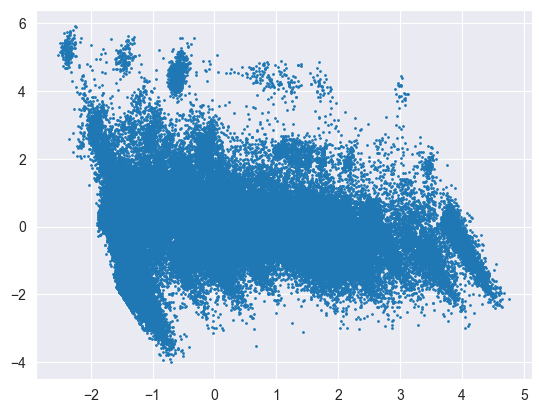

In [101]:
# pca in order to reduce the dimensionality of the dataset
pca = PCA(n_components=2)
df_incidents_pca = pca.fit_transform(df_incidents_scaled)
# plot of the results
plt.scatter(df_incidents_pca[:,0], df_incidents_pca[:,1], s=1)

## K-Means
In this section we are going to apply the K-Means algorithm to the entire dataset. We will use the elbow method and the silhouette score to select the number k of clusters. We will also see the clusters on the PCA plot in the case of the dataset scaled with StandardScaler. For the dataset scaled with MinMaxScaler, we will visualize the clusters on the scatter plots of some selected features.

### StandardScaler()

#### Elbow method and Silhouette score

In order to select the number of clusters k, we can use the elbow method: we run k-means for different values of k and, by plotting the SSE, we can see the elbow point, that gives the optimal number of clusters. We also compute the silhouette score for the clusters obtained with k-means. We subsampled the dataset because the computation was too expensive.

In [102]:
kmeans = []

SSE = []

silhouette_scores = []

for i in range(1, 11):
    kmeans.append( 
        KMeans(
            n_clusters=i, 
            random_state=0, 
            n_init=1
        ).fit(df_incidents_scaled) 
    )
    
    SSE.append(kmeans[i-1].inertia_)
    
    if i > 1:
        silhouette_scores.append(
            silhouette_score(
                df_incidents_scaled, 
                kmeans[i-1].labels_, 
                metric='euclidean',
                sample_size=50000
            )
        )

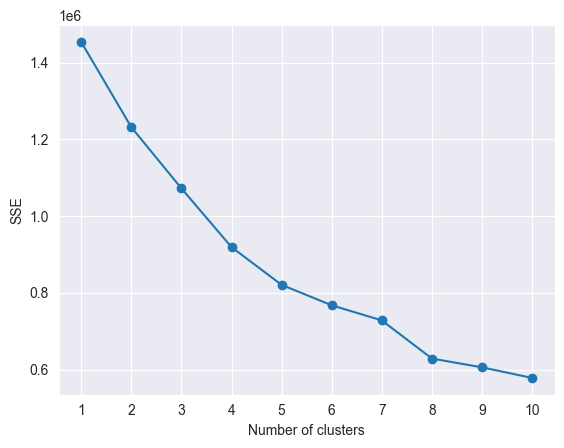

In [103]:
plt.plot( range(1,11),SSE, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
# change numbers on x axis
plt.xticks(np.arange(1, 11, step=1))
plt.show()

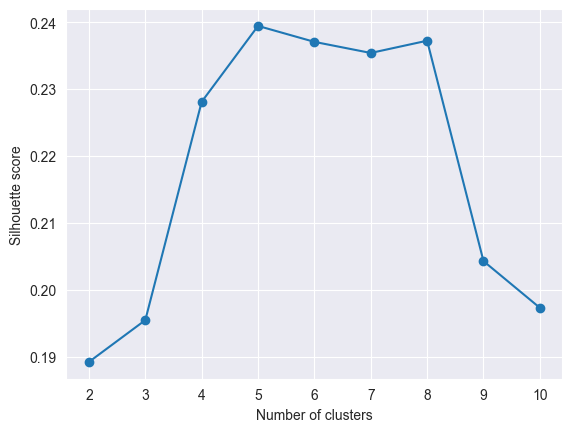

In [104]:
# We plot the silhouette scores in another plot since the scale is different than the SSE
plt.plot( range(2,11), silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
# change numbers on x axis
plt.xticks(np.arange(2, 11, step=1))
plt.show()

In [105]:
# We choose k = 5 clusters
kmeans = KMeans(n_clusters=5, random_state=0, n_init=10).fit(df_incidents_scaled)
df_incidents['cluster_kmeans'] = kmeans.labels_
df_incidents['cluster_kmeans'].value_counts()
df_incidents_clustering['cluster'] = kmeans.labels_

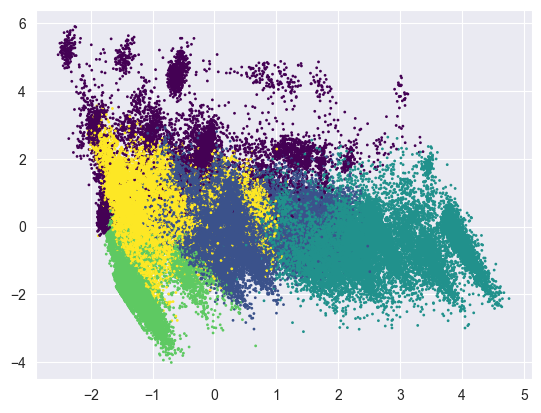

In [106]:
# We report the clusters on the PCA plot
plt.scatter(df_incidents_pca[:,0], df_incidents_pca[:,1], c=df_incidents_clustering['cluster'], s=1, cmap='viridis')

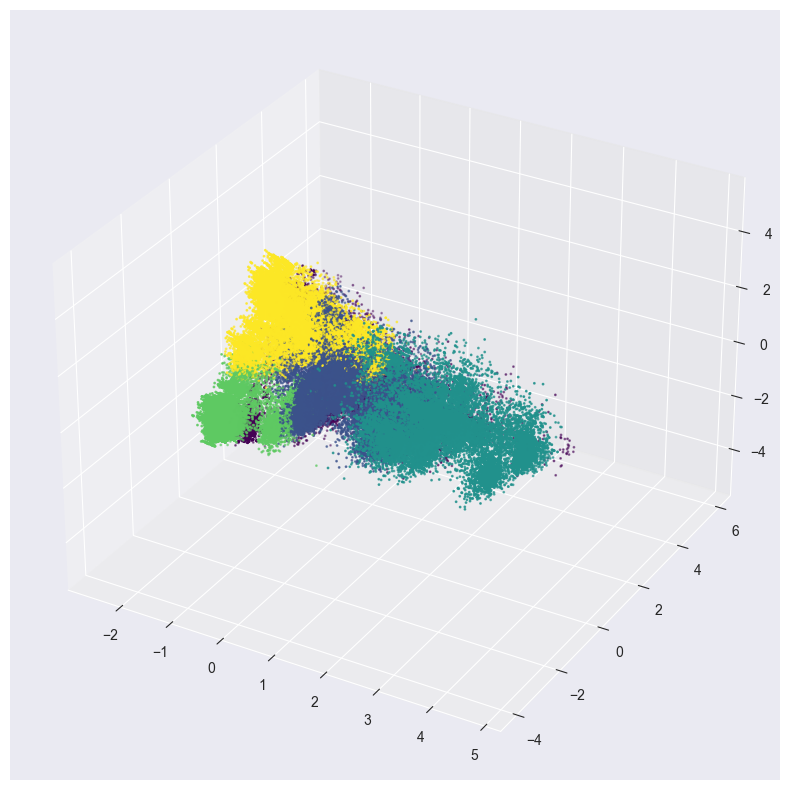

In [107]:
# plot of 3 components-PCA with clusters
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
pca= PCA(n_components=3)
df_incidents_pca = pca.fit_transform(df_incidents_scaled)
ax.scatter(df_incidents_pca[:,0], df_incidents_pca[:,1], df_incidents_pca[:,2], c=df_incidents_clustering['cluster'], s=1, cmap='viridis')

### MinMaxScaler()

#### Elbow method and Silhouette score

Analogously, we can apply the K-means algorithm to the dataset scaled with MinMaxScaler.

In [108]:
kmeans_mm = []

SSE_mm = []

silhouette_scores_mm = []

for i in range(1, 11):
    kmeans_mm.append( 
        KMeans(
            n_clusters=i, 
            random_state=0, 
            n_init=1
        ).fit(df_incidents_scaled_mm) 
    )
    
    SSE_mm.append(kmeans_mm[i-1].inertia_)
    
    if i > 1:
        silhouette_scores_mm.append(
            silhouette_score(
                df_incidents_scaled_mm, 
                kmeans_mm[i-1].labels_, 
                metric='euclidean',
                sample_size=50000
            )
        )

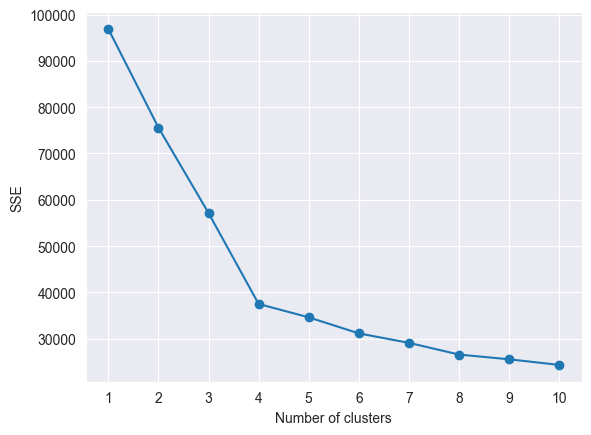

In [109]:
plt.plot( range(1,11),SSE_mm, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
# change numbers on x axis
plt.xticks(np.arange(1, 11, step=1))
plt.show()

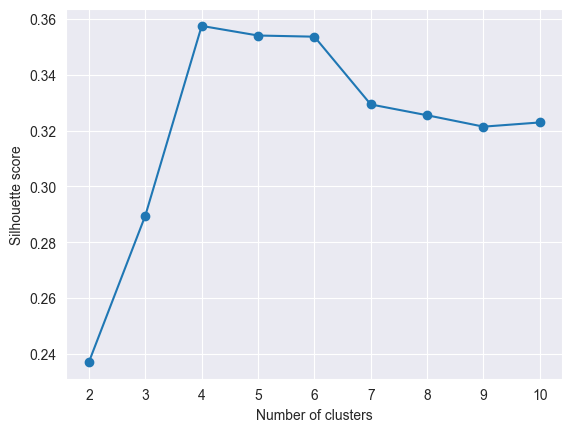

In [110]:
# We plot the silhouette scores in another plot since the scale is different than the SSE
plt.plot( range(2,11), silhouette_scores_mm, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
# change numbers on x axis
plt.xticks(np.arange(2, 11, step=1))
plt.show()

In [111]:
# We choose k = 4 clusters
kmeans_mm = KMeans(n_clusters=4, random_state=0, n_init=10).fit(df_incidents_scaled_mm)
df_incidents['cluster_kmeans_mm'] = kmeans_mm.labels_
df_incidents['cluster_kmeans_mm'].value_counts()
df_incidents_clustering['cluster_mm'] = kmeans_mm.labels_

Let's see the clusters on the scatter plots of some selected features.

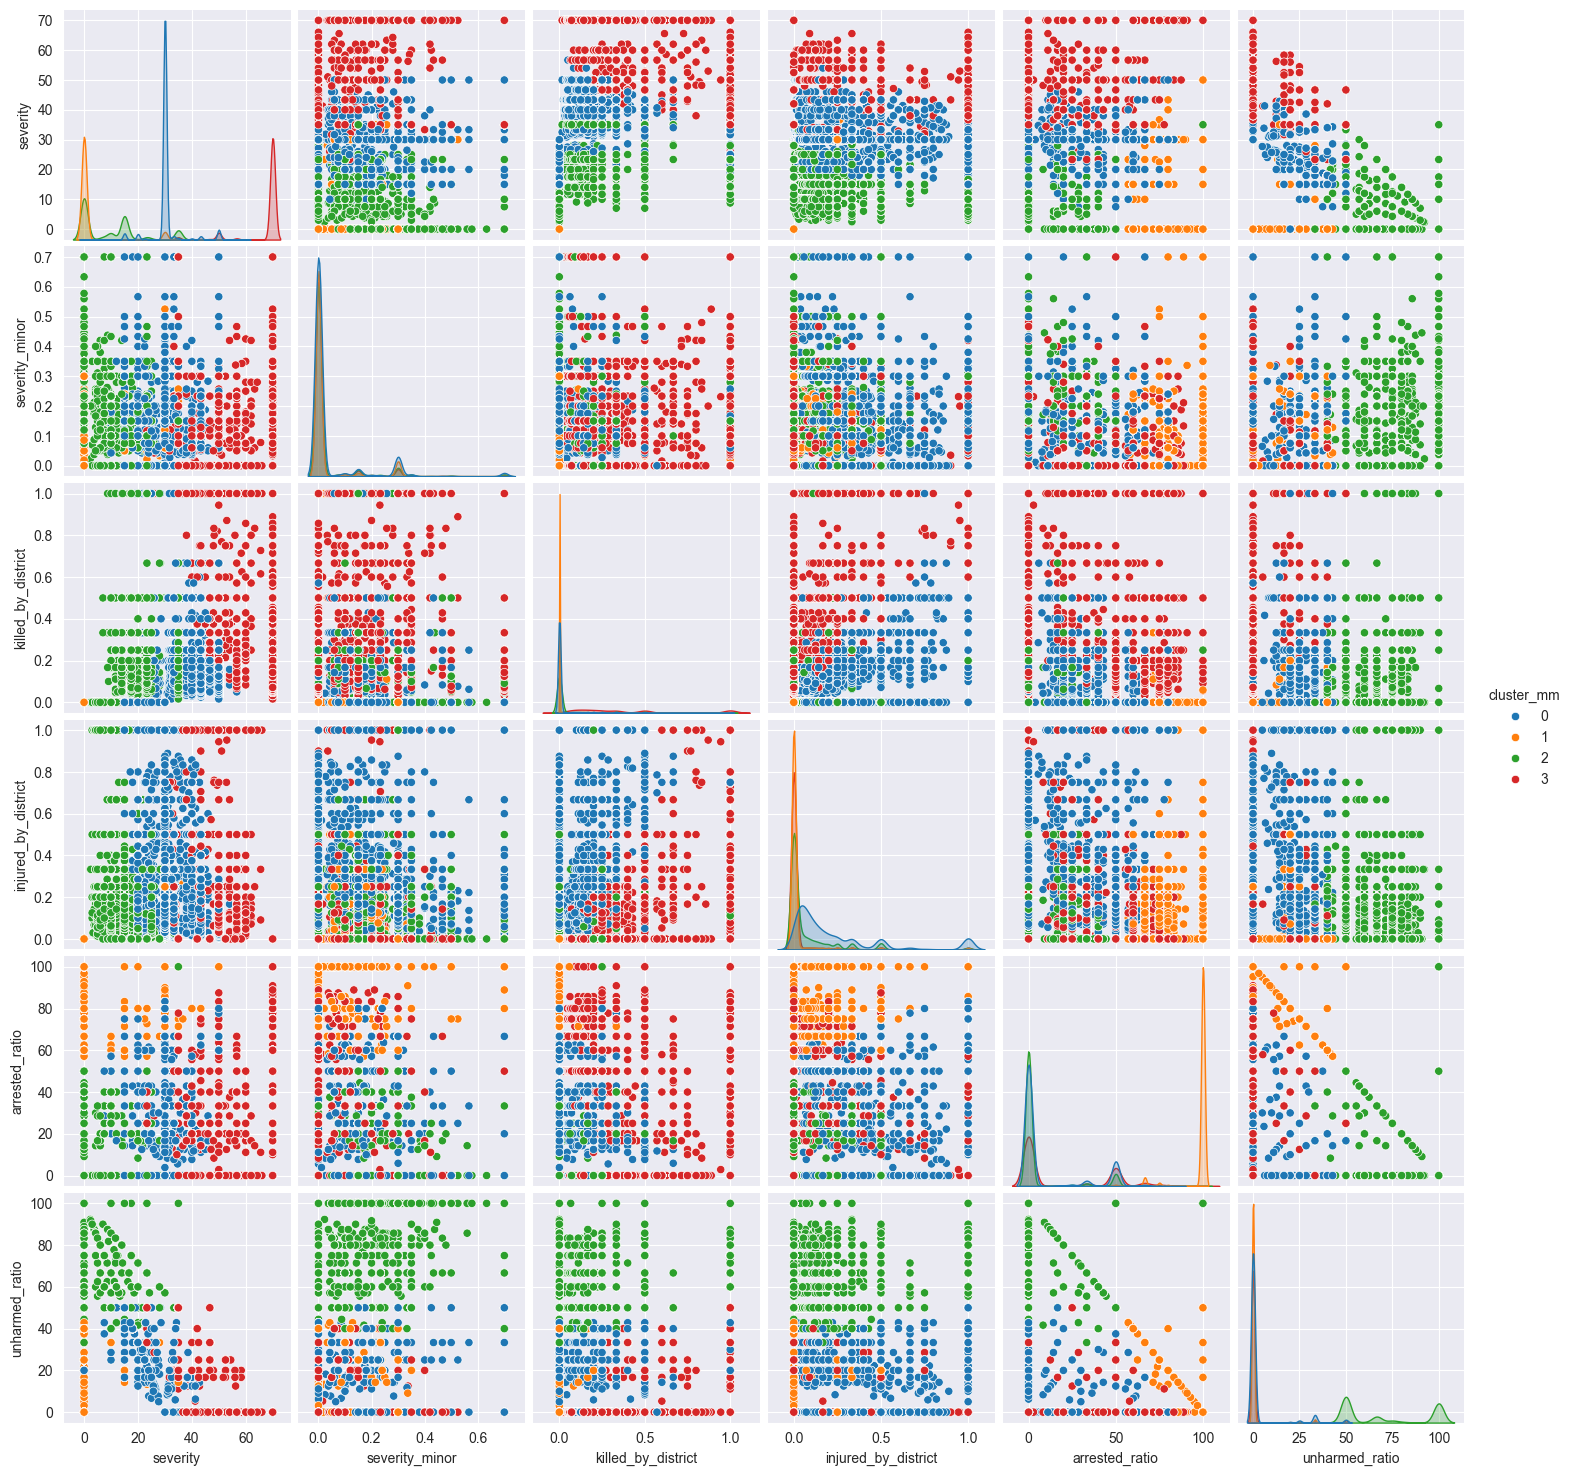

In [112]:
feature_scatter = [
    'severity', 
    'severity_minor',
    'killed_by_district',
    'injured_by_district',
    'arrested_ratio',
    'unharmed_ratio',
    'cluster_mm'
]
sns.pairplot(df_incidents_clustering[feature_scatter], hue='cluster_mm', palette=sns.color_palette(n_colors=4))
plt.show()

Considering that the silhouette score is not very high, we can say that the clusters are not too bad. Still, this could indicate that there are not well-defined natural clusters in the dataset. We can also say that the clusters obtained with MinMaxScaler are better since the silhouette score is higher.

We can also select 3 features and visualize the clusters in a 3D plot. We choose `severity`, `killed_by_district` and `unharmed_ratio`.

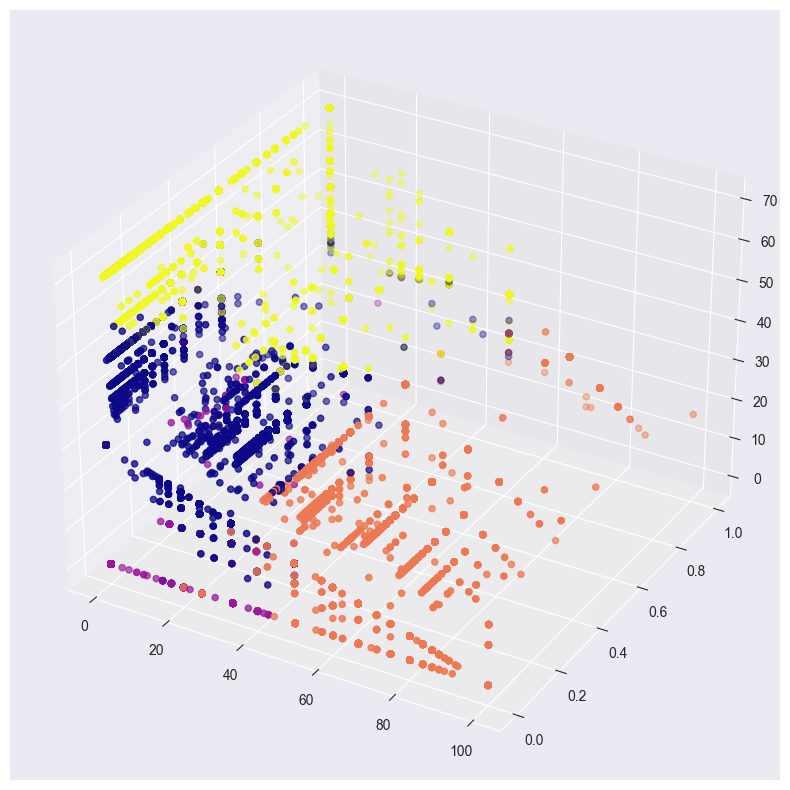

In [113]:
# Visualize the scatter plot of the 3 features colouring the points according to the 4 clusters
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(
    df_incidents_clustering['unharmed_ratio'], 
    df_incidents_clustering['killed_by_district'], 
    df_incidents_clustering['severity'], 
    c=df_incidents_clustering['cluster_mm'], 
    cmap='plasma'
)

### Killed people in the clusters

Let's see the distribution of killed people in the 4 clusters obtained with StandardScaler and MinMaxScaler. This could be useful to understand if the clusters capture different types of incidents.

In [114]:
df_incidents.shape

(161550, 34)

In [115]:
df_incidents_clustering.shape

(161550, 11)

In [116]:
# To do this analysis, we need to add back the feature `n_killed`
df_incidents_clustering['n_killed'] = df_incidents['n_killed']

In [117]:
df_incidents_clustering.columns

Index(['avg_age_participants', 'povertyPercentage', 'severity',
       'severity_minor', 'killed_by_district', 'injured_by_district',
       'arrested_ratio', 'unharmed_ratio', 'right_or_left', 'cluster',
       'cluster_mm', 'n_killed'],
      dtype='object')

In [118]:
# see the values of cluster_kmeans_mm
df_incidents_clustering['cluster'].value_counts()

cluster
1    57530
4    35455
3    31908
2    24355
0    12302
Name: count, dtype: int64

In [119]:
# see the values of cluster_kmeans_mm
df_incidents_clustering['cluster_mm'].value_counts()

cluster_mm
0    52154
2    39153
3    35171
1    35072
Name: count, dtype: int64

Cluster 0: 2418 killed over 51271 total killed people
Cluster 1: 15290 killed over 51271 total killed people
Cluster 2: 29027 killed over 51271 total killed people
Cluster 3: 15 killed over 51271 total killed people
Cluster 4: 4521 killed over 51271 total killed people


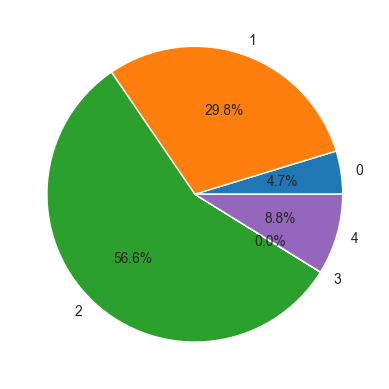

In [120]:
for k in range(5):
    killed_per_cluster = df_incidents_clustering[df_incidents_clustering['cluster']==k]['n_killed'].sum()
    print('Cluster {}: {} killed'.format(k, killed_per_cluster), 'over', df_incidents_clustering['n_killed'].sum(), 'total killed people')
# pie plot to see the percentage of killed people in each cluster
plt.pie(df_incidents_clustering.groupby('cluster')['n_killed'].sum(), labels=['0', '1', '2', '3', '4'], autopct='%1.1f%%')
plt.show()

Cluster 0: 4601 killed over 51271 total killed people
Cluster 1: 33 killed over 51271 total killed people
Cluster 2: 5930 killed over 51271 total killed people
Cluster 3: 40707 killed over 51271 total killed people


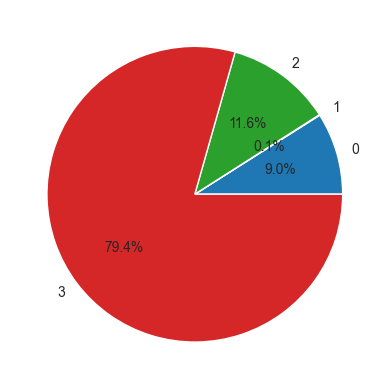

In [121]:
for k in range(4):
    killed_per_cluster_mm = df_incidents_clustering[df_incidents_clustering['cluster_mm']==k]['n_killed'].sum()
    print('Cluster {}: {} killed'.format(k, killed_per_cluster_mm), 'over', df_incidents_clustering['n_killed'].sum(), 'total killed people')
# pie plot to see the percentage of killed people in each cluster
plt.pie(df_incidents_clustering.groupby('cluster_mm')['n_killed'].sum(), labels=['0', '1', '2', '3'], autopct='%1.1f%%')
plt.show()

We can notice that in the clusters obtained with MinMaxScaler, the percentage of killed people is very high in the cluster 3, meaning that it captures the most severe incidents. On the other hand, the cluster 1 captures the incidents with the lowest number of killed people.

Let's see the distribution of the feature `unharmed_ratio` in the clusters that have a low percentage of killed people.

In [122]:
# Let's see the distributions of other features in the clusters 0, 1
print(
    '\n', 'Cluster 0 - StandardScaler, mean of unharmed_ratio:',
    df_incidents_clustering[df_incidents_clustering['cluster']==0].unharmed_ratio.mean(),
    '\n', 'Cluster 4 - StandardScaler, mean of unharmed_ratio:',
    df_incidents_clustering[df_incidents_clustering['cluster']==4].unharmed_ratio.mean(),
    '\n\n', 'Cluster 0 - MinMaxScaler, mean of unharmed_ratio:',
    df_incidents_clustering[df_incidents_clustering['cluster_mm']==0].unharmed_ratio.mean(),
    '\n', 'Cluster 1 - MinMaxScaler, mean of unharmed_ratio:',
    df_incidents_clustering[df_incidents_clustering['cluster_mm']==1].unharmed_ratio.mean(),
    '\n', 'Cluster 2 - MinMaxScaler, mean of unharmed_ratio:',
    df_incidents_clustering[df_incidents_clustering['cluster_mm']==2].unharmed_ratio.mean()
)


 Cluster 0 - StandardScaler, mean of unharmed_ratio: 15.58891352271434 
 Cluster 4 - StandardScaler, mean of unharmed_ratio: 71.11956782934078 

 Cluster 0 - MinMaxScaler, mean of unharmed_ratio: 2.6634215513769615 
 Cluster 1 - MinMaxScaler, mean of unharmed_ratio: 0.757636376736247 
 Cluster 2 - MinMaxScaler, mean of unharmed_ratio: 70.65540339159217


It seems that the cluster 4 with StandardScaler and the cluster 2 with MinMaxScaler capture the incidents with a high percentage of unharmed people.

### Analysis of the clusters
We choose the clusters obtained with MinMaxScaler and we analyze them.

#### Incidents' characteristics in the clusters
We start by seeing the distribution of the feature `incident_characteristics1` in the 4 clusters. We recall that we let this feature to have only 5 labels in the Data Preparation phase, keeping the labels with most instances and including all the others in the label 'Other'.

<Axes: xlabel='cluster_kmeans_mm', ylabel='count'>

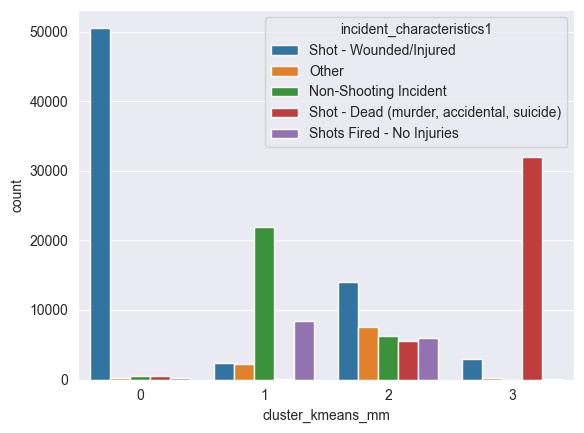

In [123]:
sns.countplot(data=df_incidents, x='cluster_kmeans_mm', hue='incident_characteristics1')

We notice that the cluster 0 consists mainly of incidents with the label 'Shot - Wounded/Injured', and the cluster 3 mainly of 'Shot - Dead' incidents. 

The cluster 1 mostly has 'Non-Shooting Incident' and 'Shots Fired - No Injuries' incidents meaning that it captures the incidents with lowest severity. 

Finally, the cluster 2 is a mix of all the labels.

In [124]:
# By curiosity let's see the severity of the incidents in the clusters
print(
    '\n', 'Cluster 0 - MinMaxScaler, mean of severity:',
    df_incidents_clustering[df_incidents_clustering['cluster_mm']==0].severity.mean(),
    '\n', 'Cluster 1 - MinMaxScaler, mean of severity:',
    df_incidents_clustering[df_incidents_clustering['cluster_mm']==1].severity.mean(),
    '\n', 'Cluster 2 - MinMaxScaler, mean of severity:',
    df_incidents_clustering[df_incidents_clustering['cluster_mm']==2].severity.mean(),
    '\n', 'Cluster 3 - MinMaxScaler, mean of severity:',
    df_incidents_clustering[df_incidents_clustering['cluster_mm']==3].severity.mean()
)


 Cluster 0 - MinMaxScaler, mean of severity: 30.443226958823306 
 Cluster 1 - MinMaxScaler, mean of severity: 2.164323867092457 
 Cluster 2 - MinMaxScaler, mean of severity: 9.660156104604804 
 Cluster 3 - MinMaxScaler, mean of severity: 67.49928726041895


We can see that these results are consistent with the distribution of the labels of `incident_characteristics1`.

#### KDE of the features for each cluster
In order to gain more insights on the relations between the features and the clusters, we look at the KDE plots.

In [125]:
df_incidents_clustering.columns

Index(['avg_age_participants', 'povertyPercentage', 'severity',
       'severity_minor', 'killed_by_district', 'injured_by_district',
       'arrested_ratio', 'unharmed_ratio', 'right_or_left', 'cluster',
       'cluster_mm', 'n_killed'],
      dtype='object')

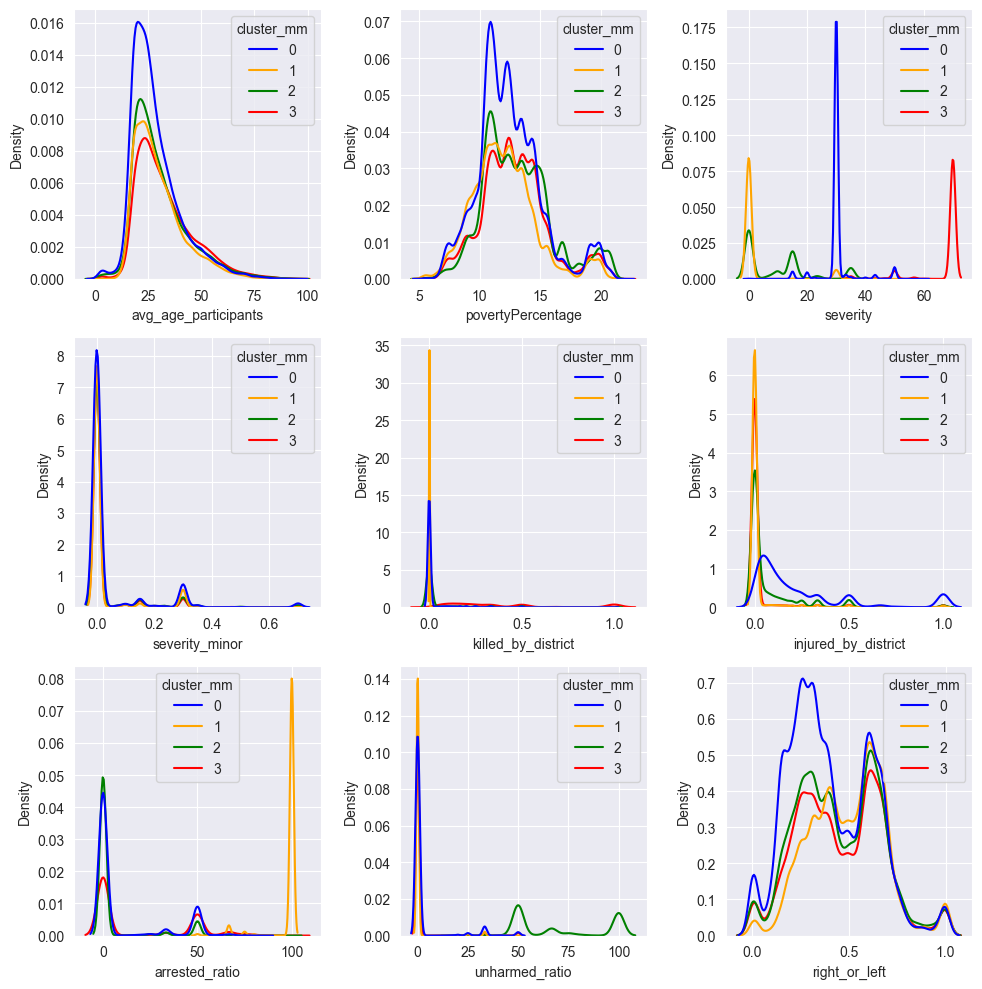

In [126]:
fig, axs = plt.subplots(3, 3, figsize=(10,10))
for i, col in enumerate(df_incidents_clustering.columns.drop(['cluster', 'cluster_mm', 'n_killed'])):
    sns.kdeplot(df_incidents_clustering, x=col, hue='cluster_mm',  ax=axs[i // 3, i % 3], palette=['blue', 'orange', 'green', 'red'])

plt.tight_layout()
plt.show()

We see that some features are more discriminative than others. For example, the feature `severity` is very discriminative: at least three of the four clusters have very different modes.
 On the other hand, `povertyPercentage` is not very explanatory. This could lead to think that the poverty percentage of the area is not a good indicator of the specific severity of individual incidents. This attribute could be more important in an aggregated framework, where we do not consider the single incidents, but the number of incidents in a certain area.

### Validating the clusters

#### Silhouette score
We compute the silhouette score for the clusters obtained with 4-Means with MinMaxScaler. We subsample the dataset because the computation is too expensive.

In [127]:
silhouette_score(df_incidents_scaled_mm, df_incidents_clustering['cluster_mm'], sample_size=50000)

0.3594177735232318

As already said, the fact that the silhouette score is not very high suggests that there are not well-defined natural clusters in the dataset. We decide to compute also the Calinski-Harabasz score, which is another metric to evaluate the goodness of the clusters.

#### Calinski-Harabasz score
The Calinski-Harabasz index is defined as the ratio of the between-cluster variance to the within-cluster variance, normalized by their number of degrees of freedom
$CH = \frac{BCSS}{WCSS}*\frac{k-1}{n-k}$
where:
- $BCSS$ is the between-cluster sum of squares, i.e., the weighted sum of the squared Euclidean distances between each cluster centroid and the overall dataset centroid, where the weights are given by the number of instances in the cluster
- $WCSS$ is the within-cluster sum of squares, i.e., the sum of the squared Euclidean distances between each instance and its cluster centroid
- $k$ is the number of clusters
- $n$ is the number of instances

The higher the score, the better the clusters, since the CH index is higher when the clusters are dense and well separated, which relates to a standard concept of a cluster.

In [128]:
from sklearn.metrics import calinski_harabasz_score

print(
    '\n',
    'Calinski-Harabasz score for the clusters obtained with StandardScaler:',
    calinski_harabasz_score(df_incidents_scaled, df_incidents['cluster_kmeans']),
    '\n',
    'Calinski-Harabasz score for the clusters obtained with MinMaxScaler:',
    calinski_harabasz_score(df_incidents_scaled_mm, df_incidents['cluster_kmeans_mm'])
)


 Calinski-Harabasz score for the clusters obtained with StandardScaler: 32256.142727396258 
 Calinski-Harabasz score for the clusters obtained with MinMaxScaler: 85271.108552449


We conclude that the clusters obtained with MinMaxScaler are better than the ones obtained with StandardScaler.

#### Matrix of pairwise distances
We also consider the matrix of pairwise distances $D=(D_{ij})$, where $D_{ij}$ is the distance between the $i$-th and $j$-th points. Unfortunately, due to the size of the dataset, the whole matrix is impossible to compute. We subsample the dataset and compute the pairwise distances on the subsample.

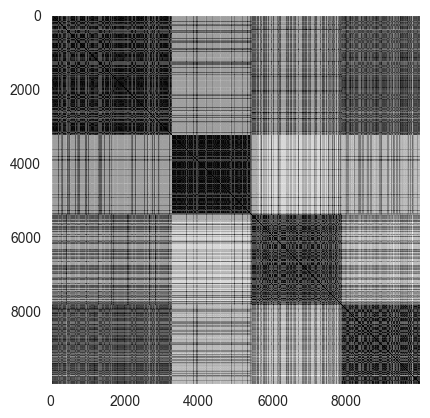

In [129]:
from sklearn.metrics import pairwise_distances
# take a subset of 10000 instances from the dataset
df_incidents_clustering_subset = df_incidents_clustering.sample(10000)
# order the subset by the cluster labels (obtained with MinMaxScaler)
df_incidents_clustering_subset = df_incidents_clustering_subset.sort_values(by='cluster_mm')
# compute the pairwise distances
distances = pairwise_distances(df_incidents_clustering_subset)

plt.imshow(distances, cmap='gray', interpolation='none')
plt.grid(False)

Now, let's see what is the correlation between the matrix $D$ and the optimal clustering matrix $A$. 

The optimal clustering matrix is the matrix that we would obtain if we had the perfect clustering, i.e., the matrix that in position $(i,j)$ has $A_{ij}=0$ if $i$ and $j$ are in the same cluster, and $A_{ij}=1$ otherwise.

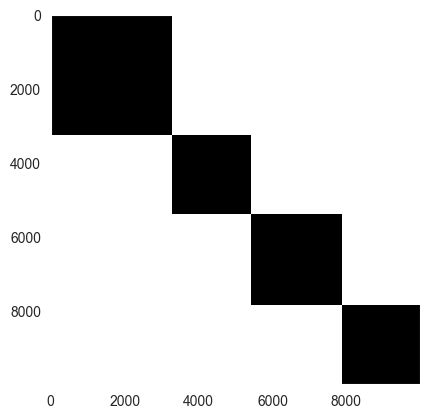

In [130]:
# The optimal distance matrix has 0 if the two points are in the same cluster, 1 otherwise
optimal_distances = np.ones(distances.shape)
# locate the indices of the points in the same cluster
same_cluster_indices = np.where(
    df_incidents_clustering_subset['cluster_mm'].values.reshape(-1,1) 
    == df_incidents_clustering_subset['cluster_mm'].values.reshape(1,-1)
)
# set the optimal distance to 0
optimal_distances[same_cluster_indices] = 0

plt.imshow(optimal_distances, cmap='gray', interpolation='none')
plt.grid(False)

And now we can see that the correlation between the two matrices is:

In [131]:
np.corrcoef(distances.reshape(-1), optimal_distances.reshape(-1))

array([[1.        , 0.66371484],
       [0.66371484, 1.        ]])

The distance matrix and the optimal matrix are fairly correlated, this can mean that the clusters are well-defined.

### Further tests 

#### Dropping killed and injured
We decided to drop a couple of features: `killed_by_district` and `injured_by_district` and see how the quality of the clusters changes. We chose these features since in the Classification task we will have to predict the number of people killed in accidents, so this analysis could provide us with some insights for future assignments.

In [132]:
# Same columns of 'cols_for_clustering' but without 'killed_by_district' and 'injured_by_district'
cols_to_keep = ['avg_age_participants', 'povertyPercentage',
       'severity', 'severity_minor', 'arrested_ratio', 'unharmed_ratio',
       'right_or_left']

In [133]:
df_incidents_clustering2 = df_incidents[cols_to_keep]

In [134]:
# Scaling 
scaler = MinMaxScaler() # we use MinMaxScaler since it gave better results
df_incidents_scaled2 = scaler.fit_transform(df_incidents_clustering2)
df_incidents_scaled2 = pd.DataFrame(df_incidents_scaled2, columns=df_incidents_clustering2.columns)

In [135]:
# Elbow method to find the optimal number of clusters
kmeans = []
SSE = []
for i in range(1, 11):
    kmeans.append( 
        KMeans(
            n_clusters=i, 
            random_state=0, 
            n_init=1
        ).fit(df_incidents_scaled2) 
    )
    SSE.append(kmeans[i-1].inertia_)

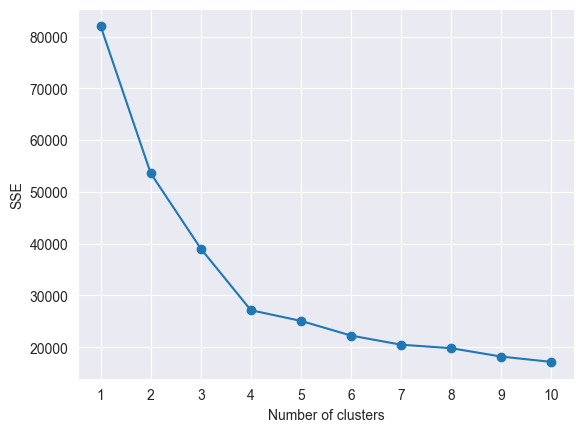

In [136]:
plt.plot( range(1,11), SSE, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
# change the numbers on the x axis
plt.xticks(np.arange(1, 11, step=1))
plt.show()

In [137]:
# We choose 4 clusters
kmeans = KMeans(n_clusters=4, random_state=0, n_init=10).fit(df_incidents_scaled2)
df_incidents['cluster_kmeans2'] = kmeans.labels_
df_incidents['cluster_kmeans2'].value_counts()
df_incidents_clustering2['cluster'] = kmeans.labels_

/var/folders/xd/64006ztx62g6gm6fh5jj4src0000gn/T/ipykernel_38608/2299301851.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_incidents_clustering2['cluster'] = kmeans.labels_


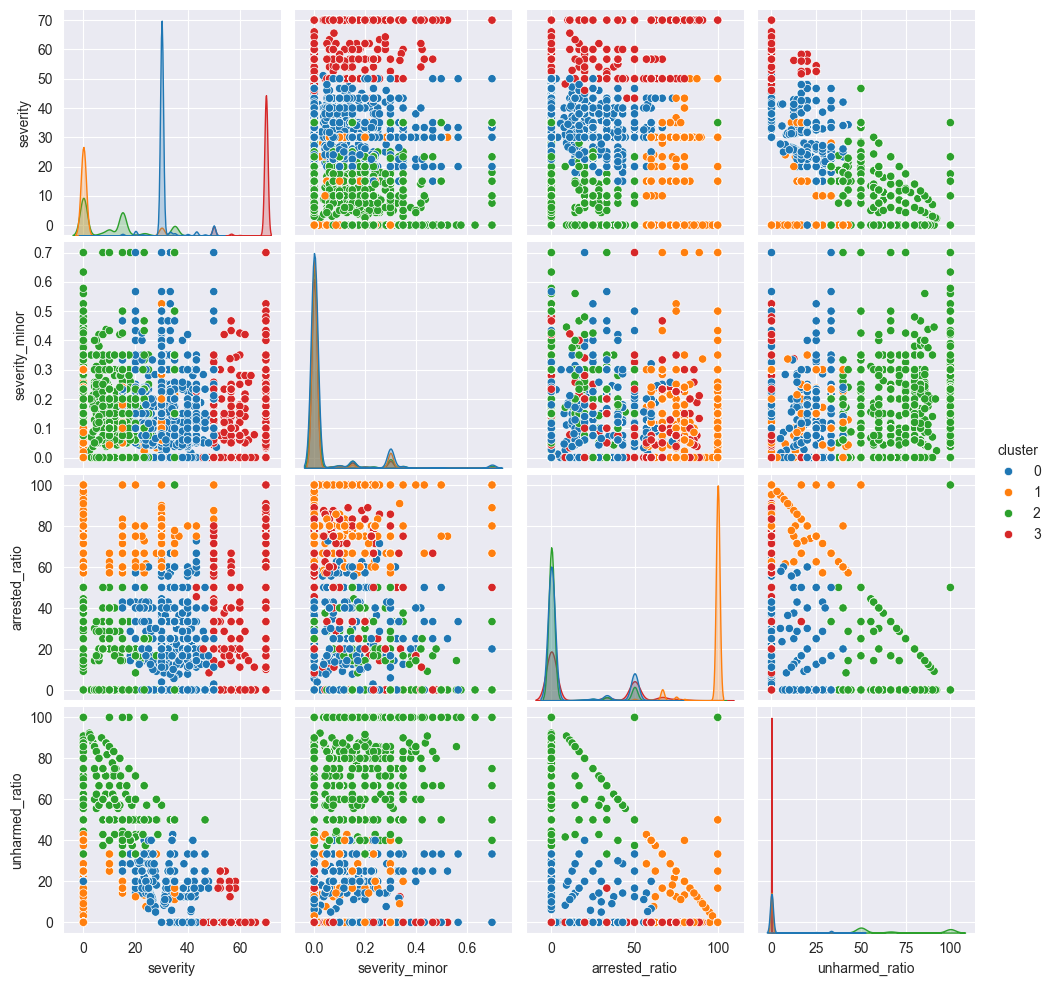

In [138]:
# Let's see the scatter plot of some selected features
feature_scatter = [
    'severity', 
    'severity_minor',
    'arrested_ratio',
    'unharmed_ratio',
    'cluster'
]
sns.pairplot(df_incidents_clustering2[feature_scatter], hue='cluster', palette=sns.color_palette(n_colors=4))

In [140]:
df_incidents_clustering2.columns

Index(['avg_age_participants', 'povertyPercentage', 'severity',
       'severity_minor', 'arrested_ratio', 'unharmed_ratio', 'right_or_left',
       'cluster'],
      dtype='object')

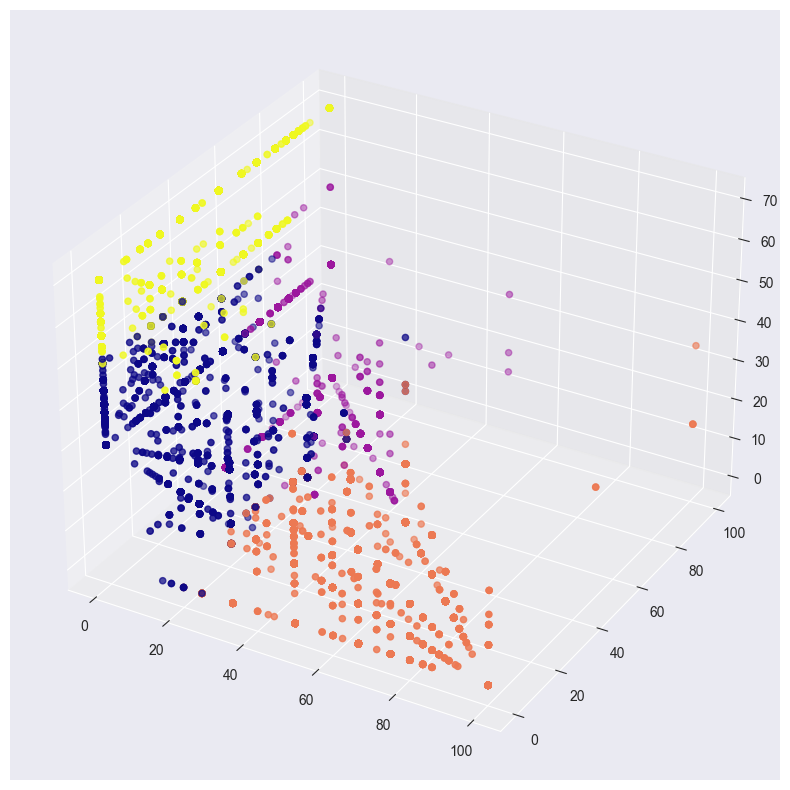

In [141]:
# Visualize the scatter plot of 3 features colouring the points according to the 4 clusters
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(
    df_incidents_clustering2['unharmed_ratio'], 
    df_incidents_clustering2['arrested_ratio'], 
    df_incidents_clustering2['severity'], 
    c=df_incidents_clustering2['cluster'], 
    cmap='plasma'
)

<Axes: xlabel='cluster_kmeans2', ylabel='count'>

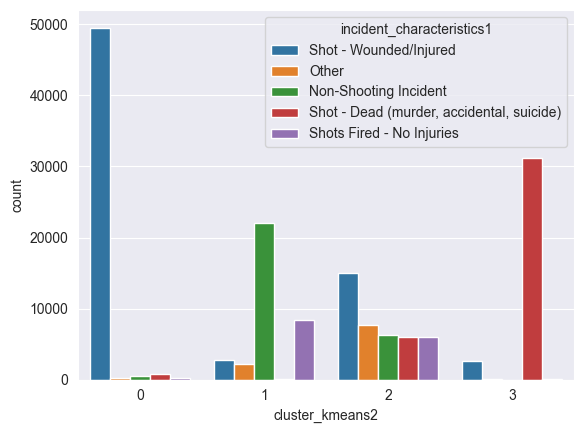

In [142]:
# Let's see the distribution of the feature 'incident_characteristics1' in the 4 clusters
sns.countplot(data=df_incidents, x='cluster_kmeans2', hue='incident_characteristics1')

It is almost identical to the case with `killed_by_district` and `injured_by_district`.

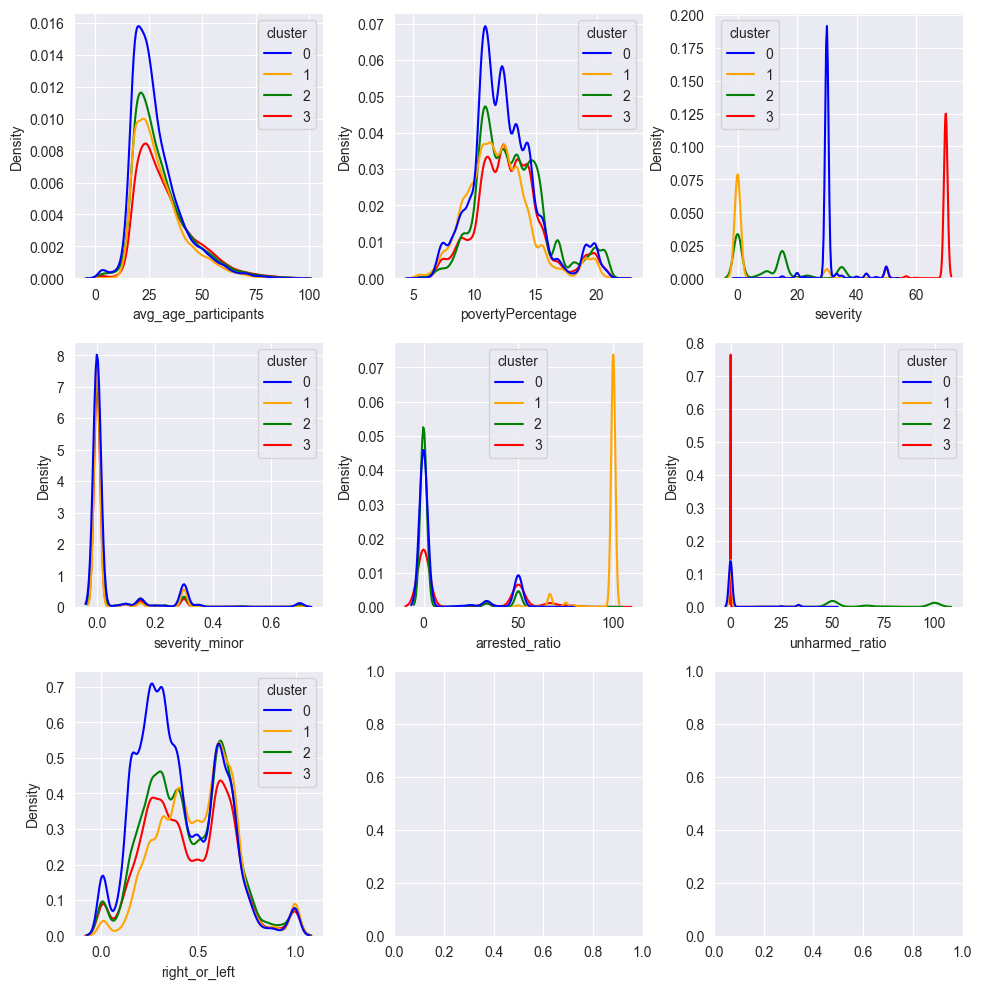

In [143]:
# Let's see the KDE plots
fig, axs = plt.subplots(3, 3, figsize=(10,10))
for i, col in enumerate(df_incidents_clustering2.columns.drop(['cluster'])):
    sns.kdeplot(df_incidents_clustering2, x=col, hue='cluster',  ax=axs[i // 3, i % 3], palette=['blue', 'orange', 'green', 'red'])
plt.tight_layout()
plt.show()

In [57]:
# Let's see the silhouette score
kmeans = []
silhouette_scores = []
for i in range(1, 11):
    kmeans.append( 
        KMeans(
            n_clusters=i, 
            random_state=0, 
            n_init=1
        ).fit(df_incidents_scaled2) 
    )
    if i > 1:
        silhouette_scores.append(
            silhouette_score(
                df_incidents_scaled2, 
                kmeans[i-1].labels_, 
                metric='euclidean',
                sample_size=50000
            )
        )

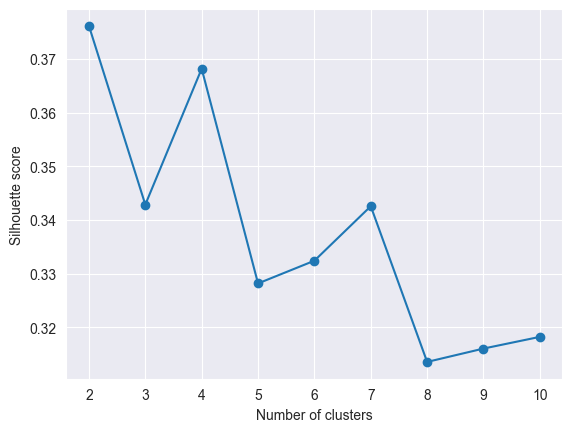

In [58]:
# We plot the silhouette scores 
plt.plot( range(2,11), silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
# change numbers on x axis
plt.xticks(np.arange(2, 11, step=1))
plt.show()

In [59]:
# Let's see with 6 clusters
kmeans = KMeans(n_clusters=6, random_state=0, n_init=10).fit(df_incidents_scaled2)
df_incidents['cluster_kmeans2'] = kmeans.labels_
df_incidents['cluster_kmeans2'].value_counts()
df_incidents_clustering2['cluster'] = kmeans.labels_

/var/folders/xd/64006ztx62g6gm6fh5jj4src0000gn/T/ipykernel_38608/3947893524.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_incidents_clustering2['cluster'] = kmeans.labels_


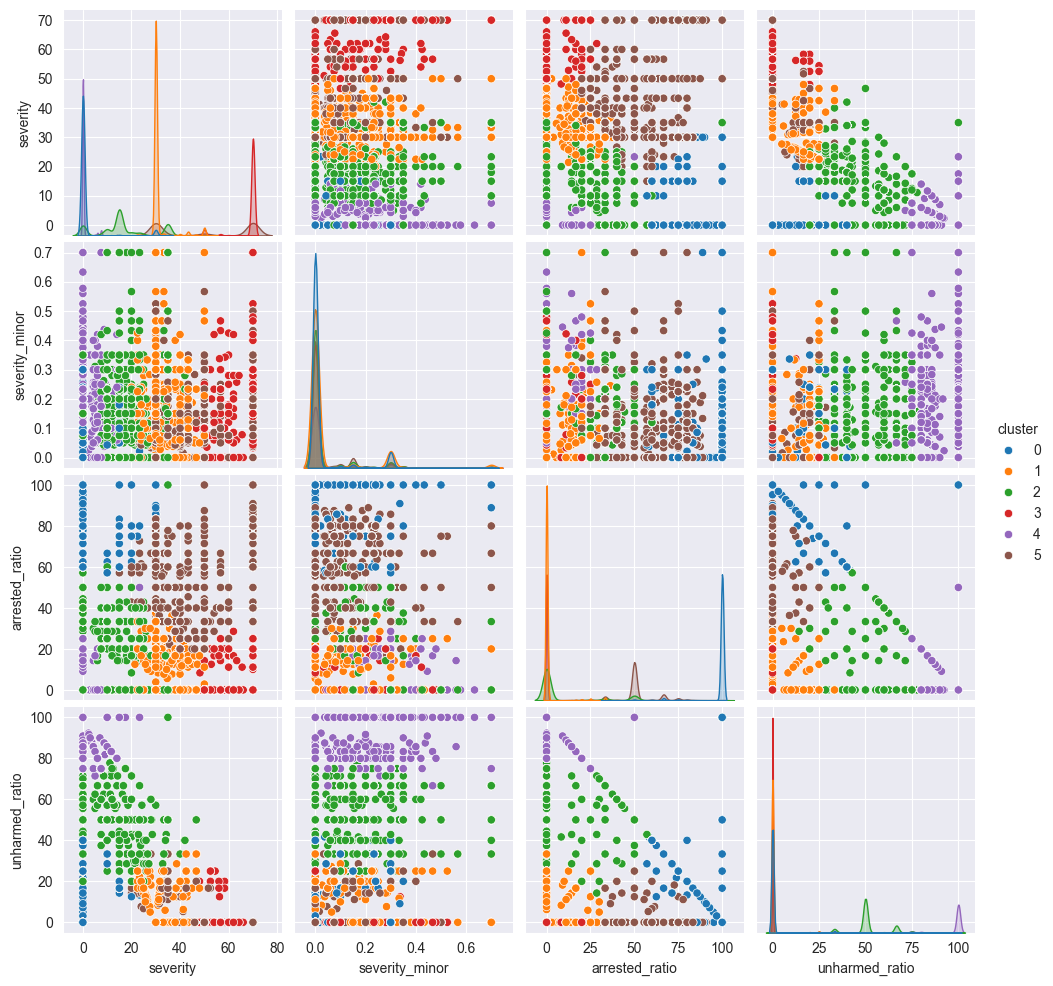

In [60]:
# Let's see the scatter plot of the selected features
feature_scatter = [
    'severity', 
    'severity_minor',
    'arrested_ratio',
    'unharmed_ratio',
    'cluster'
]
sns.pairplot(df_incidents_clustering2[feature_scatter], hue='cluster', palette=sns.color_palette(n_colors=6))

<Axes: xlabel='cluster_kmeans2', ylabel='count'>

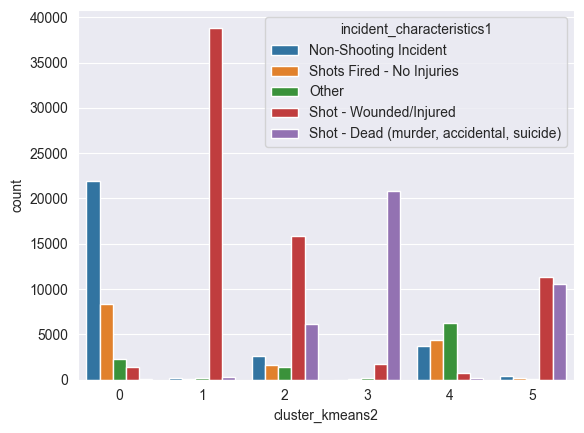

In [61]:
# Let's see the distribution of the feature 'incident_characteristics1' in the 6 clusters
sns.countplot(data=df_incidents, x='cluster_kmeans2', hue='incident_characteristics1')

Now we have more mixed clusters, even though cluster 0 captures the incidents with the lowest severity, and cluster 3 and 5 the incidents with the highest severity.

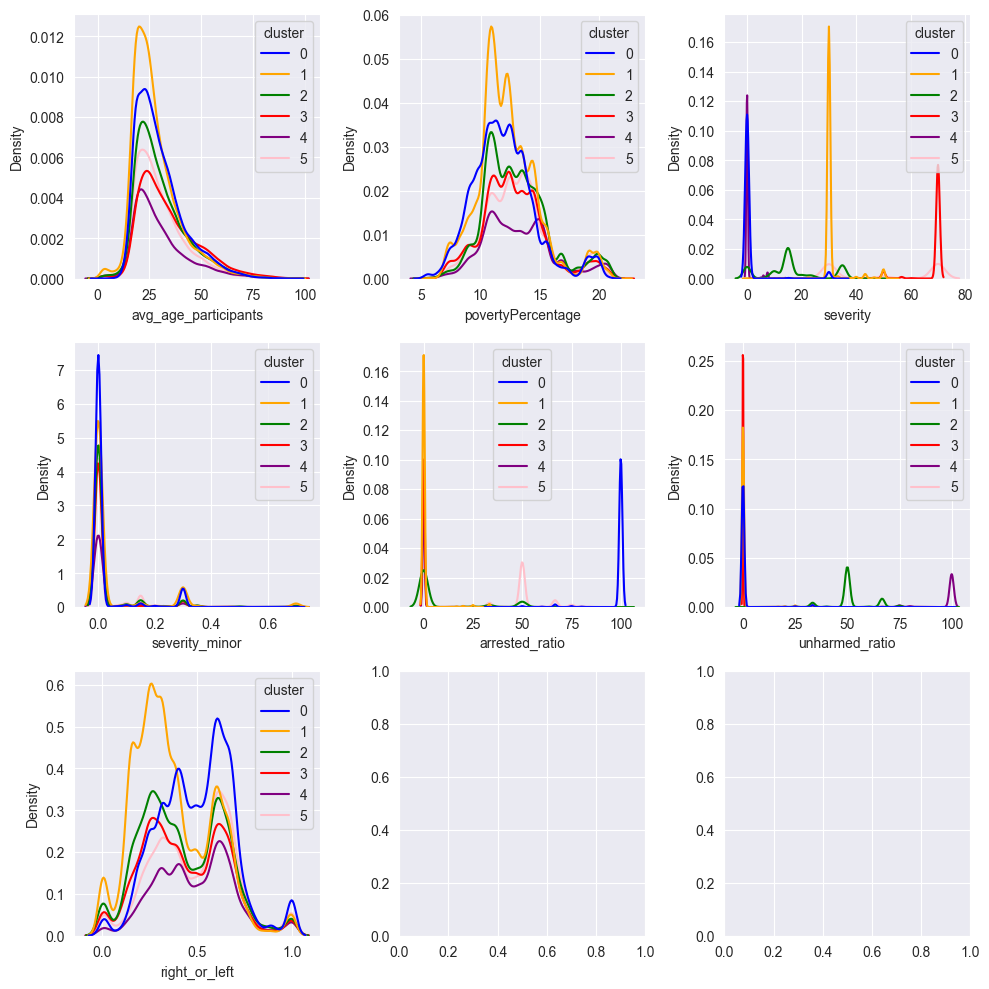

In [62]:
# Let's see the KDE plots
fig, axs = plt.subplots(3, 3, figsize=(10,10))
for i, col in enumerate(df_incidents_clustering2.columns.drop(['cluster'])):
    sns.kdeplot(df_incidents_clustering2, x=col, hue='cluster',  ax=axs[i // 3, i % 3], palette=['blue', 'orange', 'green', 'red', 'purple', 'pink'])
plt.tight_layout()
plt.show()

## K-Means on single states
We consider the most populated state: California, and the poorest and richest states: Mississippi and New Hampshire, respectively. For these states, we perform the clustering with k-means and we plot the results.

In [144]:
df_ca = df_incidents[df_incidents['state']=='california']
df_ms = df_incidents[df_incidents['state']=='mississippi']
df_nh = df_incidents[df_incidents['state']=='new hampshire']

In [145]:
cols_for_clustering =['avg_age_participants', 'povertyPercentage',
        'severity', 'severity_minor', 'killed_by_district',
       'injured_by_district', 'arrested_ratio', 'unharmed_ratio',
       'right_or_left']

In [146]:
df_ca_clustering = df_ca[cols_for_clustering]
df_ms_clustering = df_ms[cols_for_clustering]
df_nh_clustering = df_nh[cols_for_clustering]

In [147]:
# MinMaxScaling
scaler = MinMaxScaler()

df_ca_scaled = scaler.fit_transform(df_ca_clustering)
df_ca_scaled = pd.DataFrame(df_ca_scaled, columns=df_ca_clustering.columns)

df_ms_scaled = scaler.fit_transform(df_ms_clustering)
df_ms_scaled = pd.DataFrame(df_ms_scaled, columns=df_ms_clustering.columns)

df_nh_scaled = scaler.fit_transform(df_nh_clustering)
df_nh_scaled = pd.DataFrame(df_nh_scaled, columns=df_nh_clustering.columns)

### Elbow method and Silhouette score

In [148]:
kmeans_ca=[]
SSE_ca = []
silhouette_scores_ca = []
for i in range(1, 11):
    kmeans_ca.append( 
        KMeans(
            n_clusters=i, 
            random_state=0, 
            n_init=5).fit(df_ca_scaled) 
    )
    SSE_ca.append(kmeans_ca[i-1].inertia_)
    if i > 1:
        silhouette_scores_ca.append(
            silhouette_score(
                df_ca_scaled, 
                kmeans_ca[i-1].labels_, 
                metric='euclidean',
                sample_size=20000
            )
        )

In [149]:
kmeans_ms=[]
SSE_ms = []
silhouette_scores_ms = []
for i in range(1, 11):
    kmeans_ms.append( 
        KMeans(
            n_clusters=i, 
            random_state=0, 
            n_init=5).fit(df_ms_scaled) 
    )
    SSE_ms.append(kmeans_ms[i-1].inertia_)
    if i > 1:
        silhouette_scores_ms.append(
            silhouette_score(
                df_ms_scaled, 
                kmeans_ms[i-1].labels_, 
                metric='euclidean',
                sample_size=20000
            )
        )

In [150]:
kmeans_nh=[]
SSE_nh = []
silhouette_scores_nh = []
for i in range(1, 11):
    kmeans_nh.append( 
        KMeans(
            n_clusters=i, 
            random_state=0, 
            n_init=5).fit(df_nh_scaled) 
    )
    SSE_nh.append(kmeans_nh[i-1].inertia_)
    if i > 1:
        silhouette_scores_nh.append(
            silhouette_score(
                df_nh_scaled, 
                kmeans_nh[i-1].labels_, 
                metric='euclidean',
                sample_size=20000
            )
        )

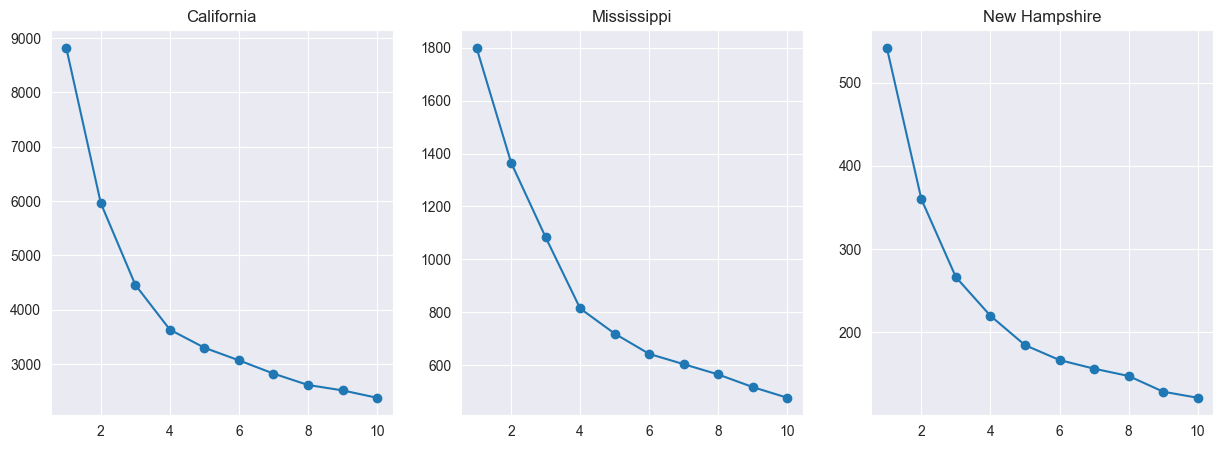

In [151]:
# SSE plots
fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].plot( range(1,11),SSE_ca, marker='o')
ax[1].plot( range(1,11),SSE_ms, marker='o')
ax[2].plot( range(1,11),SSE_nh, marker='o')
ax[0].set_title('California')
ax[1].set_title('Mississippi')
ax[2].set_title('New Hampshire')
plt.show()

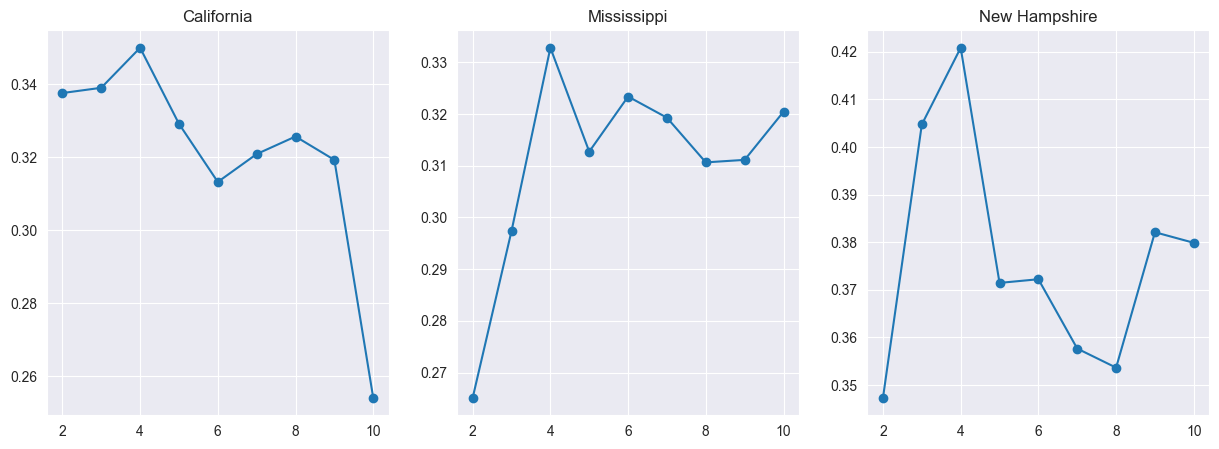

In [152]:
# Silhouette score plots
fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].plot( range(2,11),silhouette_scores_ca, marker='o')
ax[1].plot( range(2,11),silhouette_scores_ms, marker='o')
ax[2].plot( range(2,11),silhouette_scores_nh, marker='o')
ax[0].set_title('California')
ax[1].set_title('Mississippi')
ax[2].set_title('New Hampshire')
plt.show()

Considering the SSE and the Silhouette score we choose 4 clusters for all of the three states

In [153]:
kmeans_ca = KMeans(n_clusters=4, random_state=0, n_init=10).fit(df_ca_scaled)
df_ca['cluster_kmeans'] = kmeans_ca.labels_
df_ca['cluster_kmeans'].value_counts()
df_ca_clustering['cluster'] = kmeans_ca.labels_

/var/folders/xd/64006ztx62g6gm6fh5jj4src0000gn/T/ipykernel_38608/981304192.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ca['cluster_kmeans'] = kmeans_ca.labels_
/var/folders/xd/64006ztx62g6gm6fh5jj4src0000gn/T/ipykernel_38608/981304192.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ca_clustering['cluster'] = kmeans_ca.labels_


In [154]:
kmeans_ms = KMeans(n_clusters=4, random_state=0, n_init=10).fit(df_ms_scaled)
df_ms['cluster_kmeans'] = kmeans_ms.labels_
df_ms['cluster_kmeans'].value_counts()
df_ms_clustering['cluster'] = kmeans_ms.labels_

/var/folders/xd/64006ztx62g6gm6fh5jj4src0000gn/T/ipykernel_38608/3926849018.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ms['cluster_kmeans'] = kmeans_ms.labels_
/var/folders/xd/64006ztx62g6gm6fh5jj4src0000gn/T/ipykernel_38608/3926849018.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ms_clustering['cluster'] = kmeans_ms.labels_


In [155]:
kmeans_nh = KMeans(n_clusters=4, random_state=0, n_init=10).fit(df_nh_scaled)
df_nh['cluster_kmeans'] = kmeans_nh.labels_
df_nh['cluster_kmeans'].value_counts()
df_nh_clustering['cluster'] = kmeans_nh.labels_

/var/folders/xd/64006ztx62g6gm6fh5jj4src0000gn/T/ipykernel_38608/2764334325.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nh['cluster_kmeans'] = kmeans_nh.labels_
/var/folders/xd/64006ztx62g6gm6fh5jj4src0000gn/T/ipykernel_38608/2764334325.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nh_clustering['cluster'] = kmeans_nh.labels_


### Visualizations
Let's see the clusters on the scatter plots of some selected features.

In [160]:
df_ca_clustering.columns

Index(['avg_age_participants', 'povertyPercentage', 'severity',
       'severity_minor', 'killed_by_district', 'injured_by_district',
       'arrested_ratio', 'unharmed_ratio', 'right_or_left', 'cluster'],
      dtype='object')

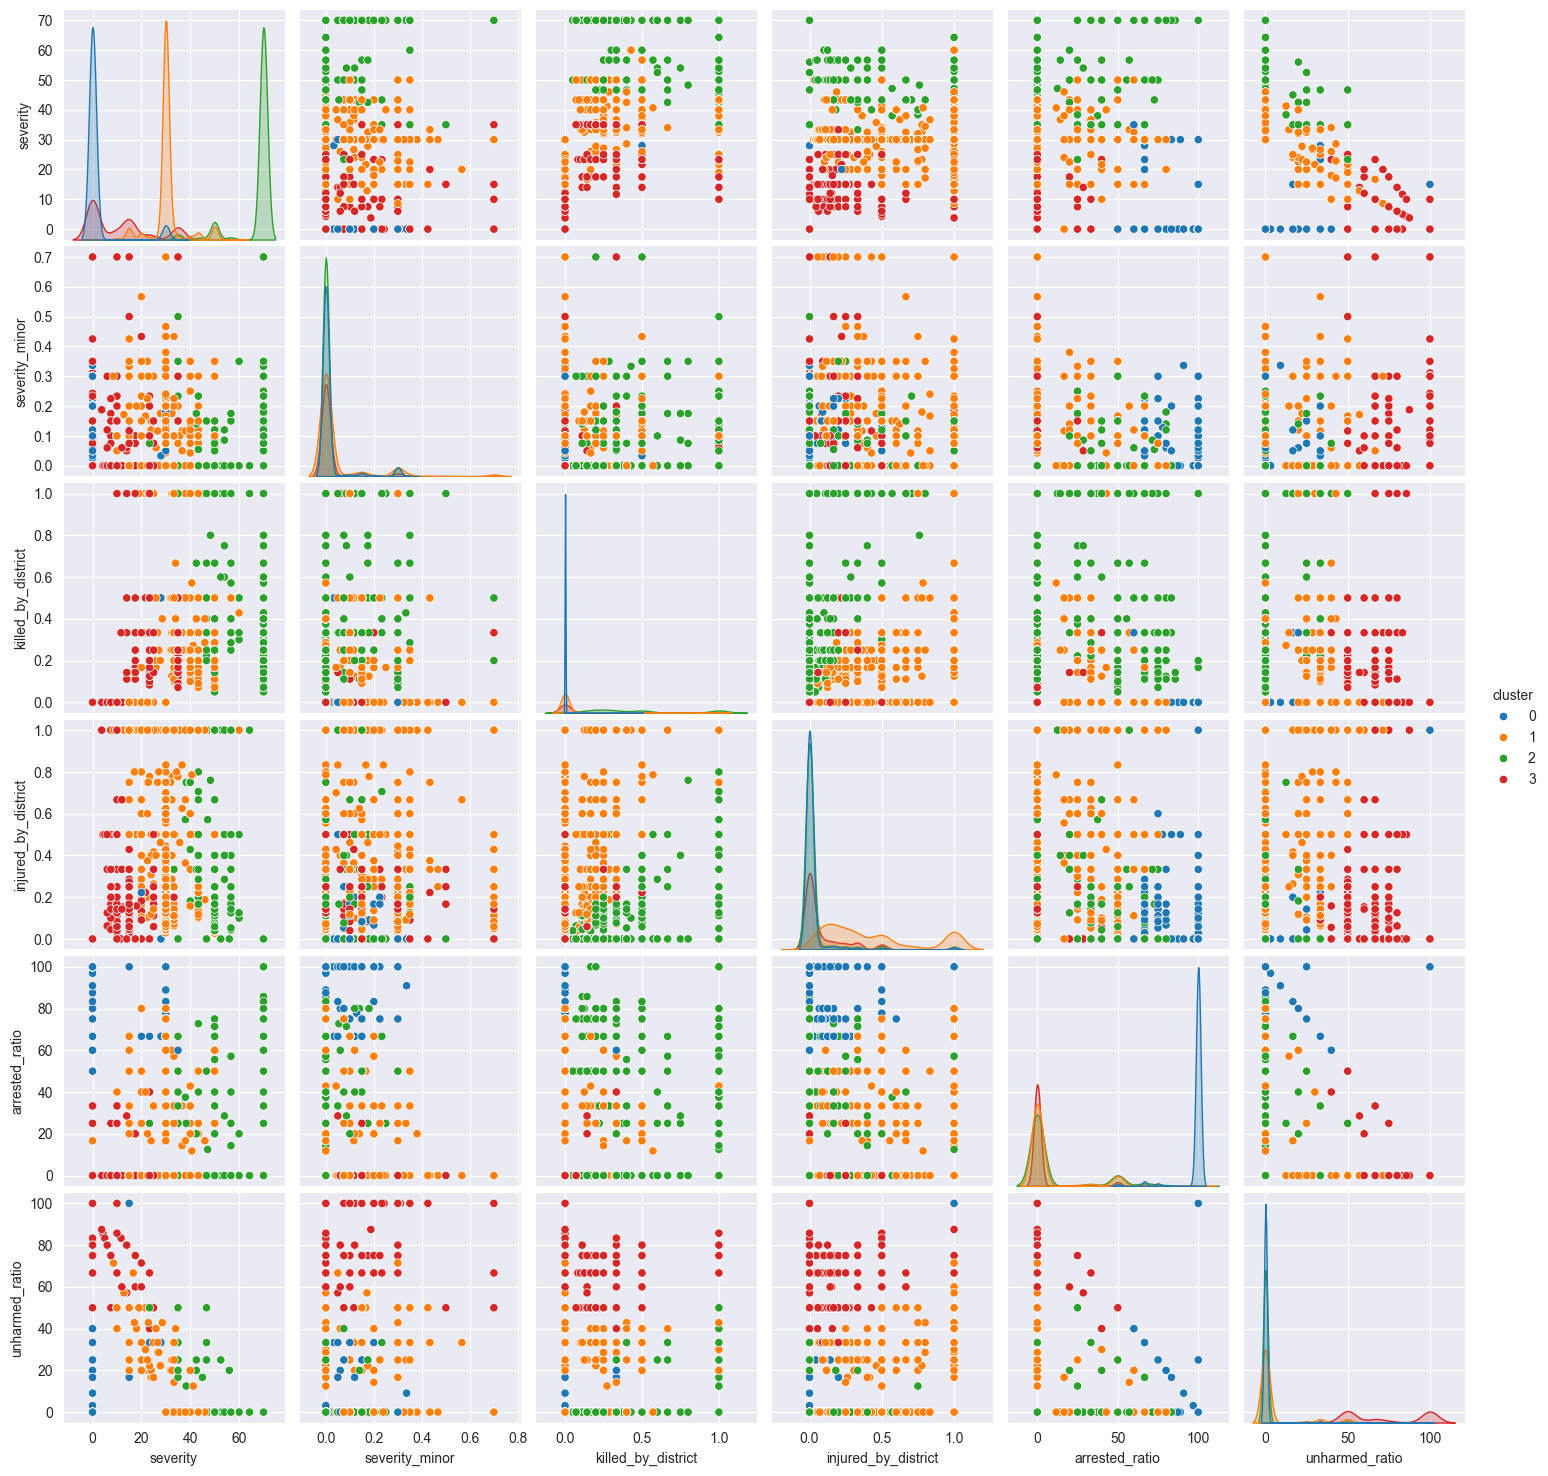

In [161]:
# CALIFORNIA
feature_scatter = [
    'severity', 
    'severity_minor',
    'killed_by_district',
    'injured_by_district',
    'arrested_ratio',
    'unharmed_ratio',
    'cluster'
]
sns.pairplot(df_ca_clustering[feature_scatter], hue='cluster', palette=sns.color_palette(n_colors=4))
plt.show()

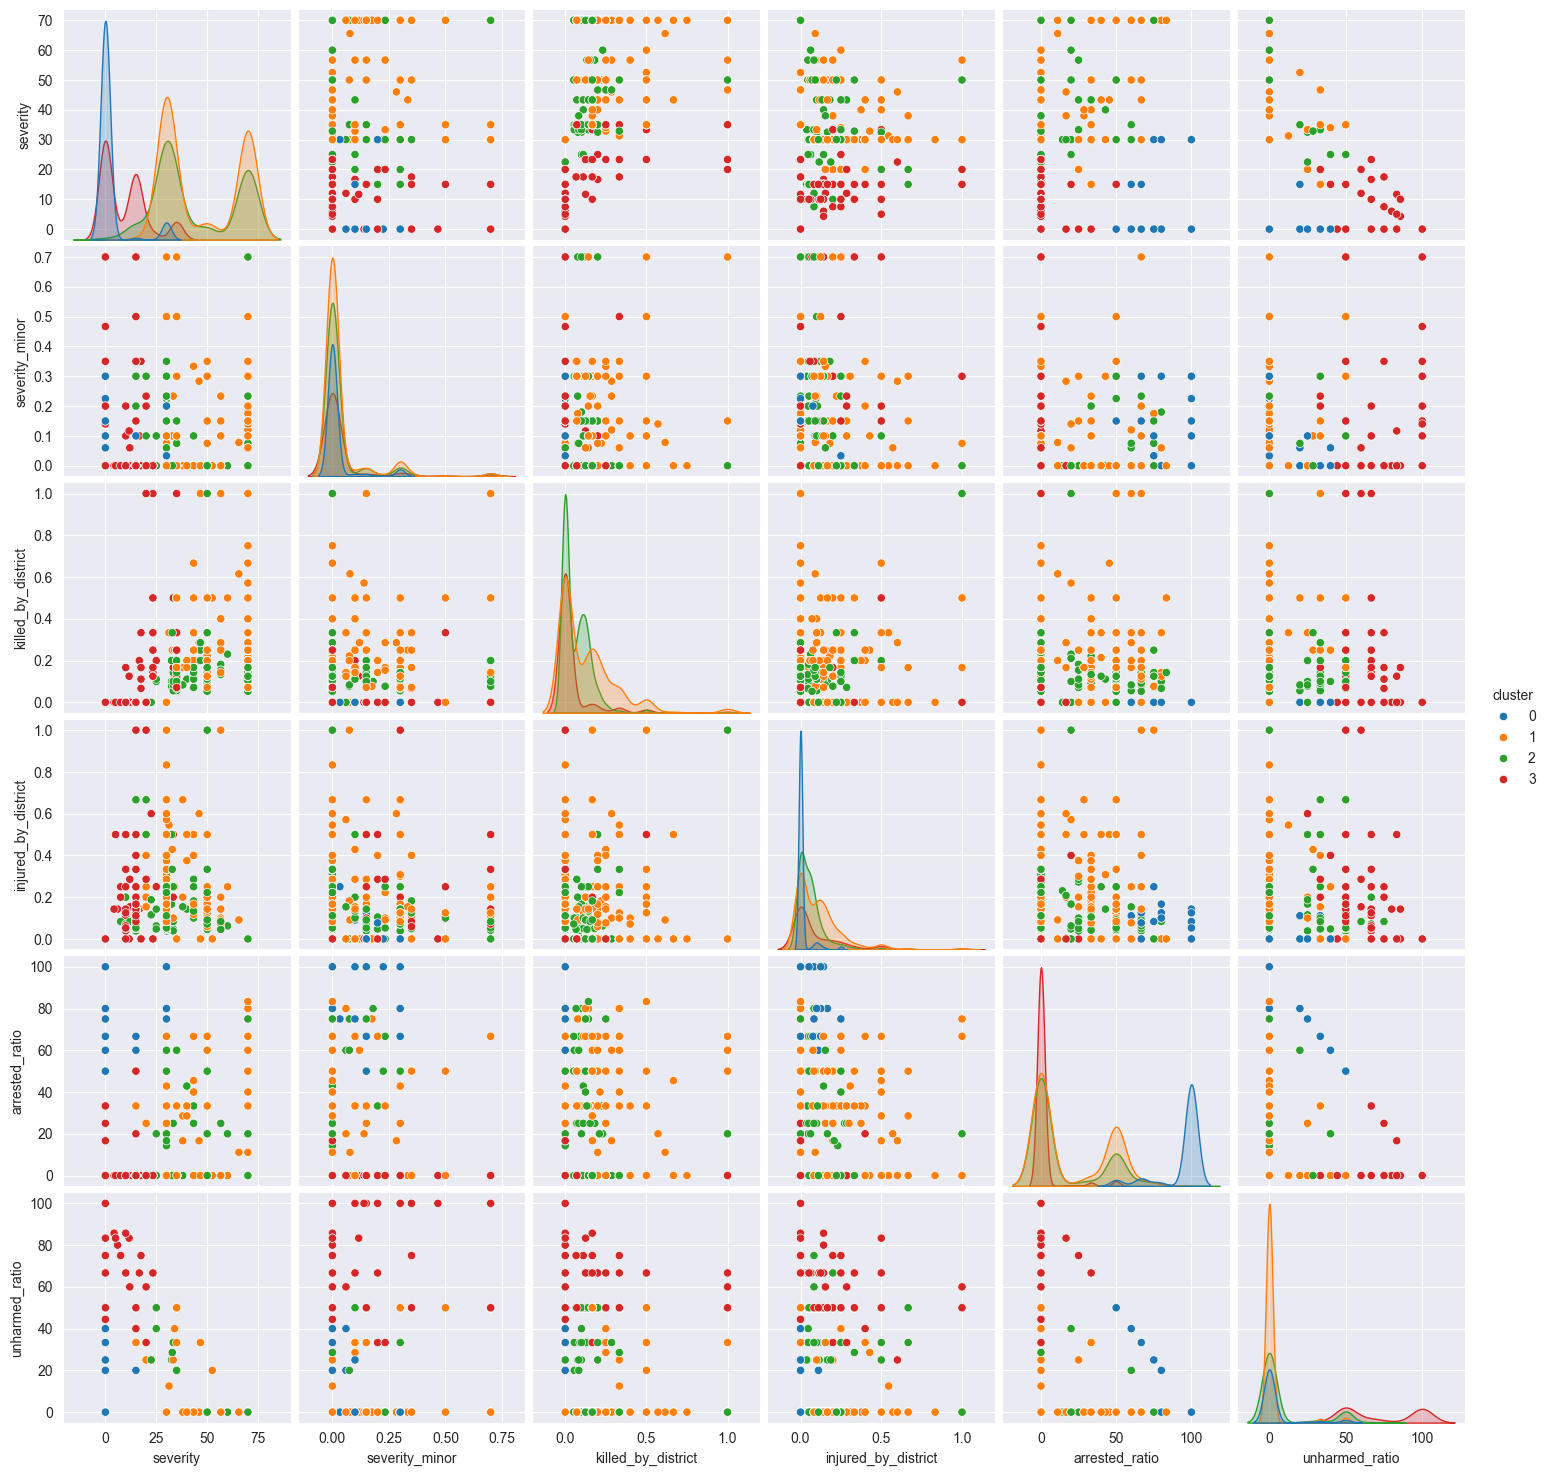

In [162]:
# MISSISSIPPI
feature_scatter = [
    'severity', 
    'severity_minor',
    'killed_by_district',
    'injured_by_district',
    'arrested_ratio',
    'unharmed_ratio',
    'cluster'
]
sns.pairplot(df_ms_clustering[feature_scatter], hue='cluster', palette=sns.color_palette(n_colors=4))
plt.show()

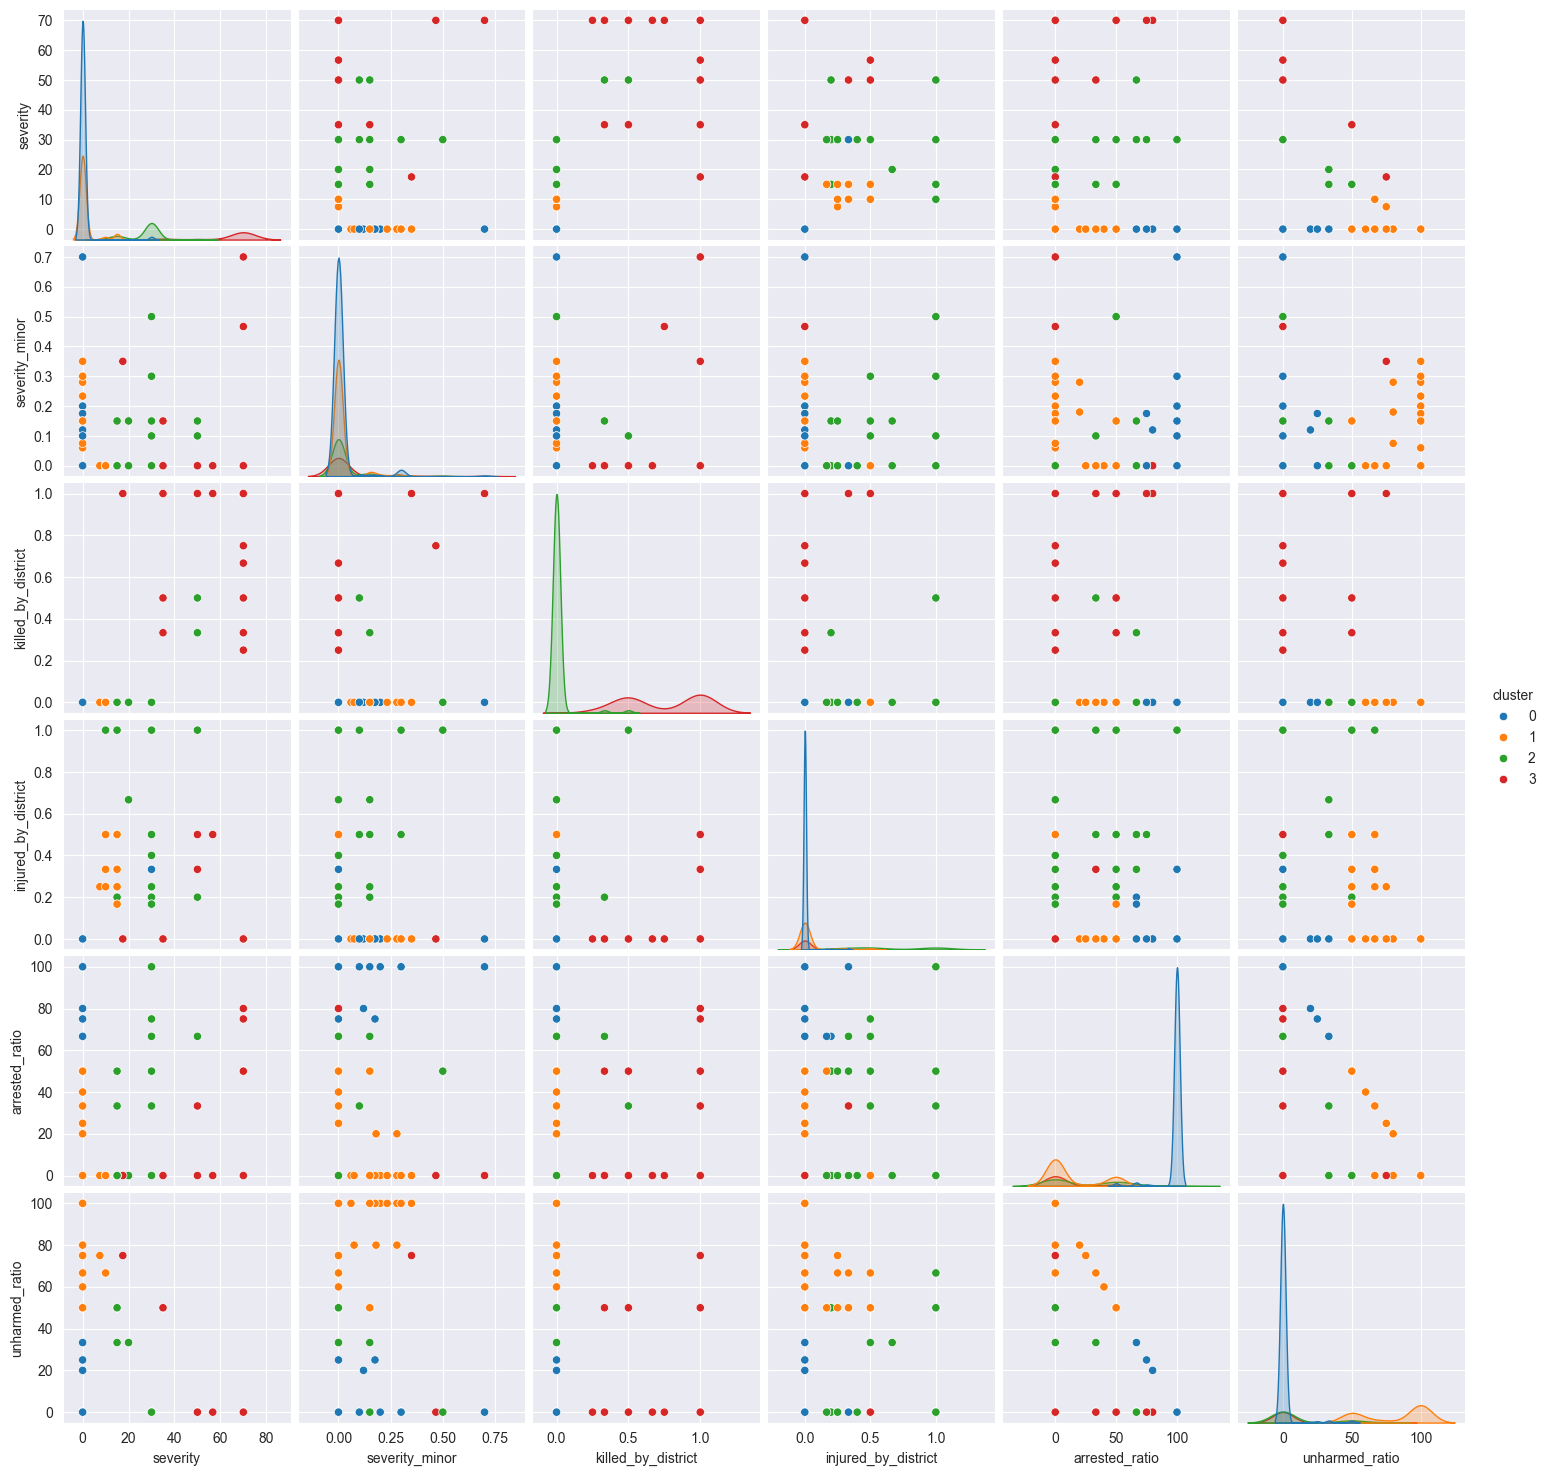

In [163]:
# NEW HAMPSHIRE
feature_scatter = [
    'severity', 
    'severity_minor',
    'killed_by_district',
    'injured_by_district',
    'arrested_ratio',
    'unharmed_ratio',
    'cluster'
]
sns.pairplot(df_nh_clustering[feature_scatter], hue='cluster', palette=sns.color_palette(n_colors=4))
plt.show()

## DBSCAN
In this section we are going to experiment with the DBSCAN algorithm. We will select California for this analysis since it is the most populated state and it seemed like the best choice to us. This reduction is necessary because this kind of analysis would require too many resources to perform on the entire dataset.

In [54]:
from sklearn.cluster import DBSCAN

In [55]:
#we drop some columns we consider as less significant: "poverty_percentage", "arrested_ratio",
#"unharmed_ratio" 
cols_for_clustering =['avg_age_participants', 
        'severity', 'severity_minor', 'killed_by_district',
       'injured_by_district', 'right_or_left']

df_incidents_clustering = df_incidents[cols_for_clustering]

In [56]:
df_ca = df_incidents[df_incidents['state']=='california']
df_ca_clustering = df_ca[cols_for_clustering]

In [57]:
df_ca_scaled = scaler.fit_transform(df_ca_clustering)

In [58]:
#pca
pca = PCA(n_components=2)
df_ca_pca = pca.fit_transform(df_ca_scaled)


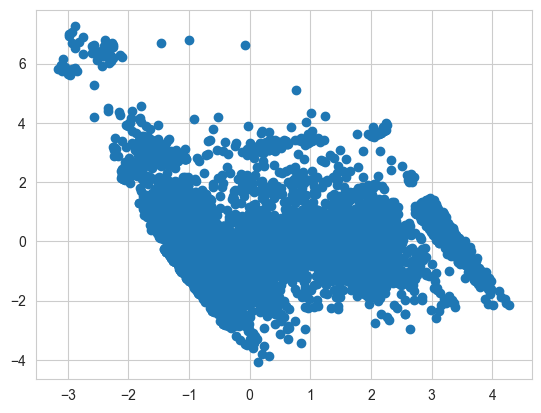

In [59]:
plt.scatter(df_ca_pca[:,0], df_ca_pca[:,1])

### Selecting the k and epsilon plotting the k-distance graph

 We run k-nn for k from 1 to 20 to visually choose our parameters

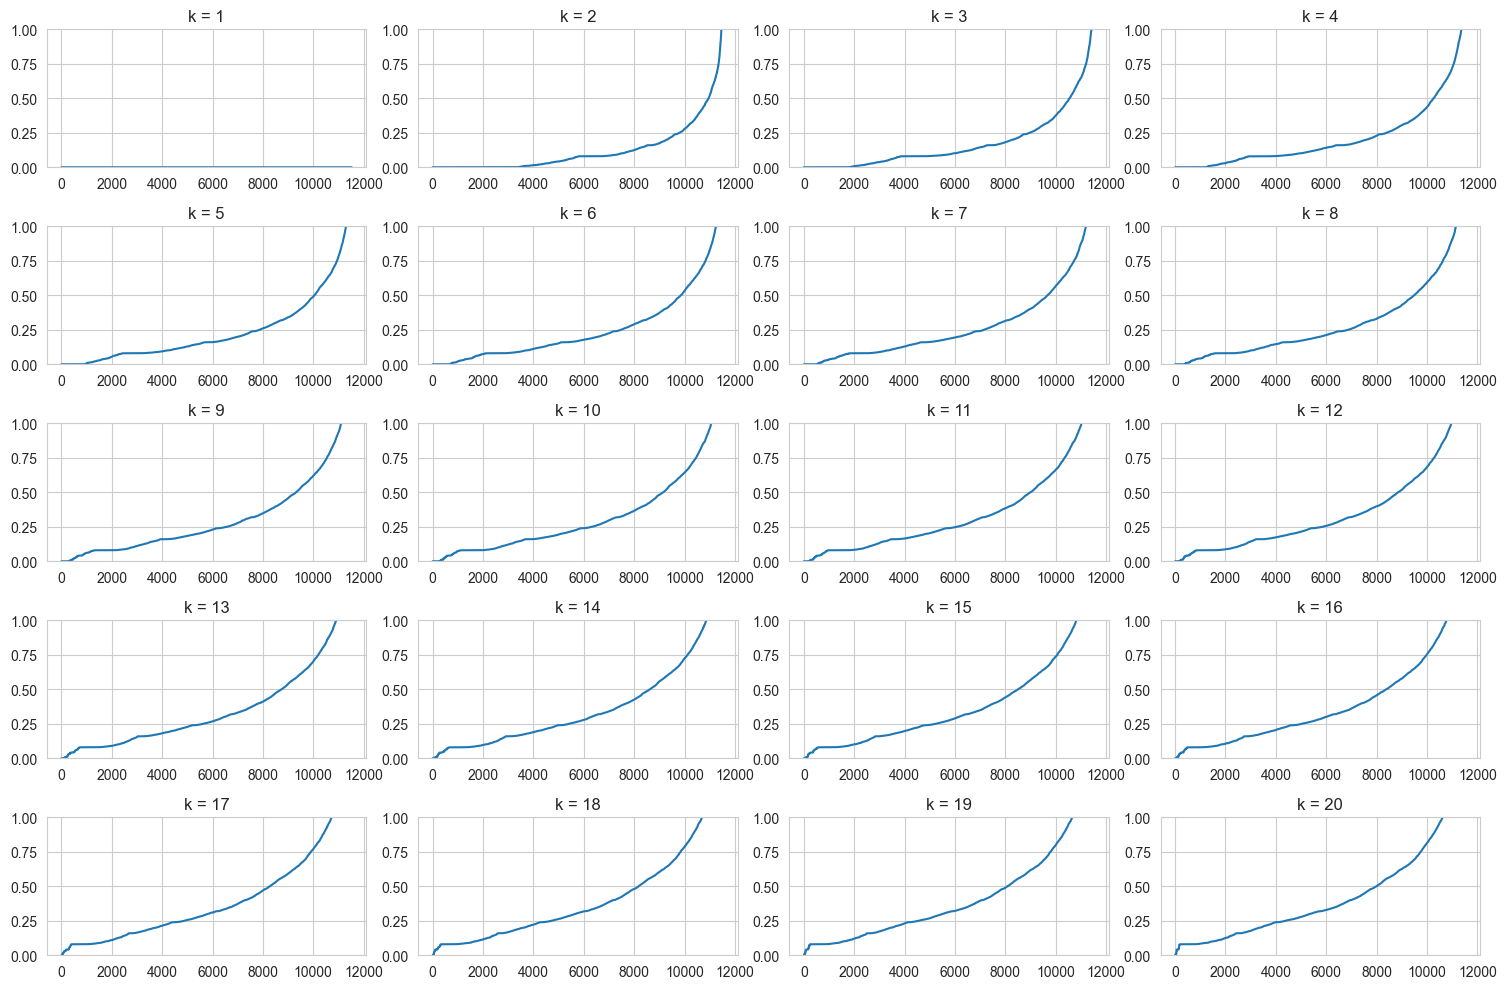

In [60]:
from sklearn.neighbors import NearestNeighbors
max_k = 20
nbrs = NearestNeighbors(n_neighbors=max_k).fit(df_ca_scaled)
fig , ax = plt.subplots(5, 4, figsize=(15,10))
for k in range(max_k):
    distances, indices = nbrs.kneighbors(df_ca_scaled)
    distances = np.sort(distances, axis=0)
    distances = distances[:,k]
    ax[k//4, k%4].plot(distances)
    ax[k//4, k%4].set_title('k = {}'.format(k+1))
    ax[k//4, k%4].set_ylim([0, 1])
plt.tight_layout()

We pick the number of points min_samples=5 and radius eps=0.85 

In [61]:
dbscan= DBSCAN(eps=0.85, min_samples=5).fit(df_ca_scaled)
df_ca['cluster_dbscan'] = dbscan.labels_
df_ca['cluster_dbscan'].value_counts()

C:\Users\HUAWEI\AppData\Local\Temp\ipykernel_32408\891136902.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ca['cluster_dbscan'] = dbscan.labels_


 0    11086
-1      235
 2       48
 1       45
 4       42
 3       26
 6       19
 9       10
 7        6
 5        6
 8        5
Name: cluster_dbscan, dtype: int64

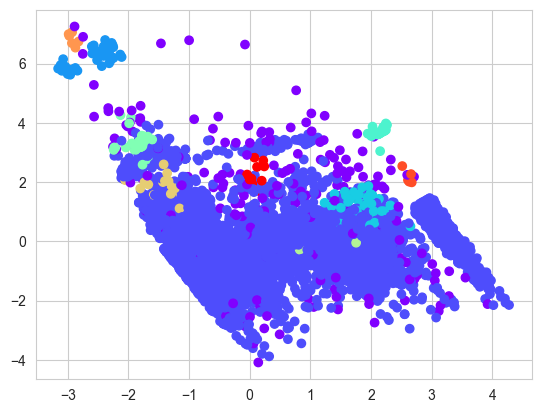

In [62]:
plt.scatter(df_ca_pca[:,0], df_ca_pca[:,1], c=df_ca['cluster_dbscan'], cmap='rainbow')

In [63]:
#plot 3d
pca= PCA(n_components=3)
df_ca_pca = pca.fit_transform(df_ca_scaled)

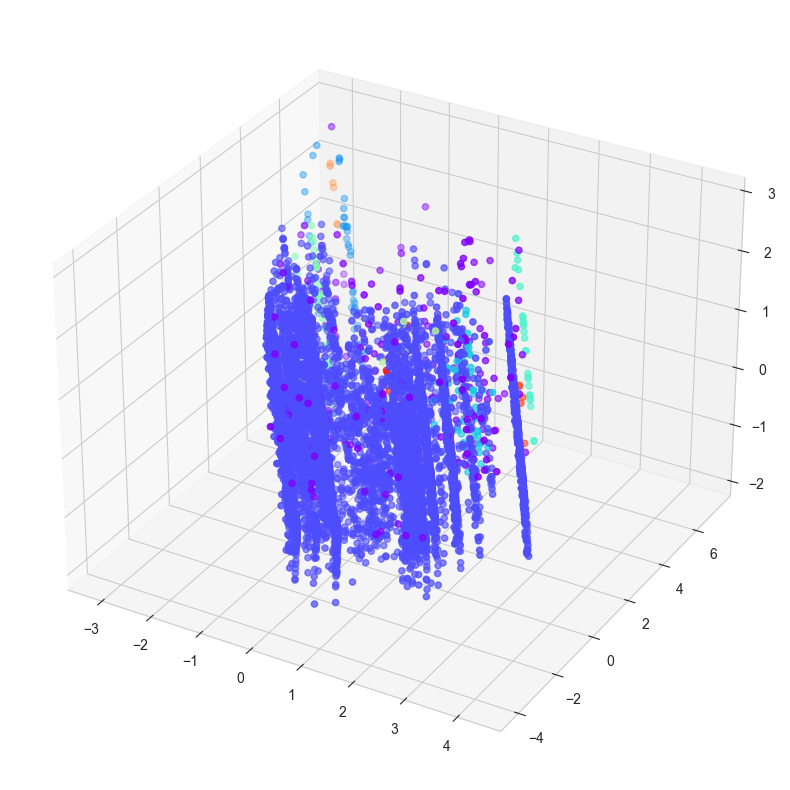

In [64]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_ca_pca[:,0], df_ca_pca[:,1], df_ca_pca[:,2], c=df_ca['cluster_dbscan'], cmap='rainbow')

### Let's repeat the same process for the state of Florida

In [65]:
df_fl = df_incidents[df_incidents['state']=='florida']
df_fl_clustering = df_fl[cols_for_clustering]

In [66]:
df_fl_scaled = scaler.fit_transform(df_fl_clustering)

In [67]:
#pca
pca = PCA(n_components=2)
df_fl_pca = pca.fit_transform(df_fl_scaled)


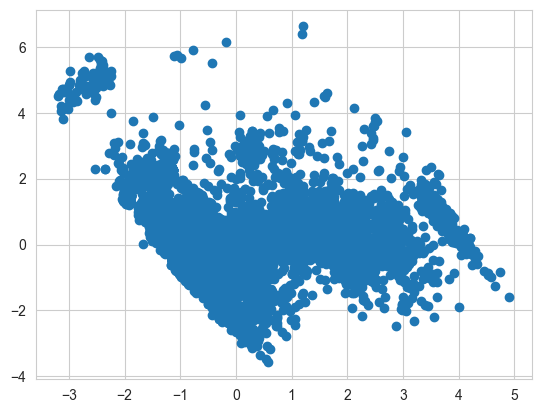

In [68]:
plt.scatter(df_fl_pca[:,0], df_fl_pca[:,1])

### Selecting the k and epsilon plotting the k-distance graph

We do as before for Florida state

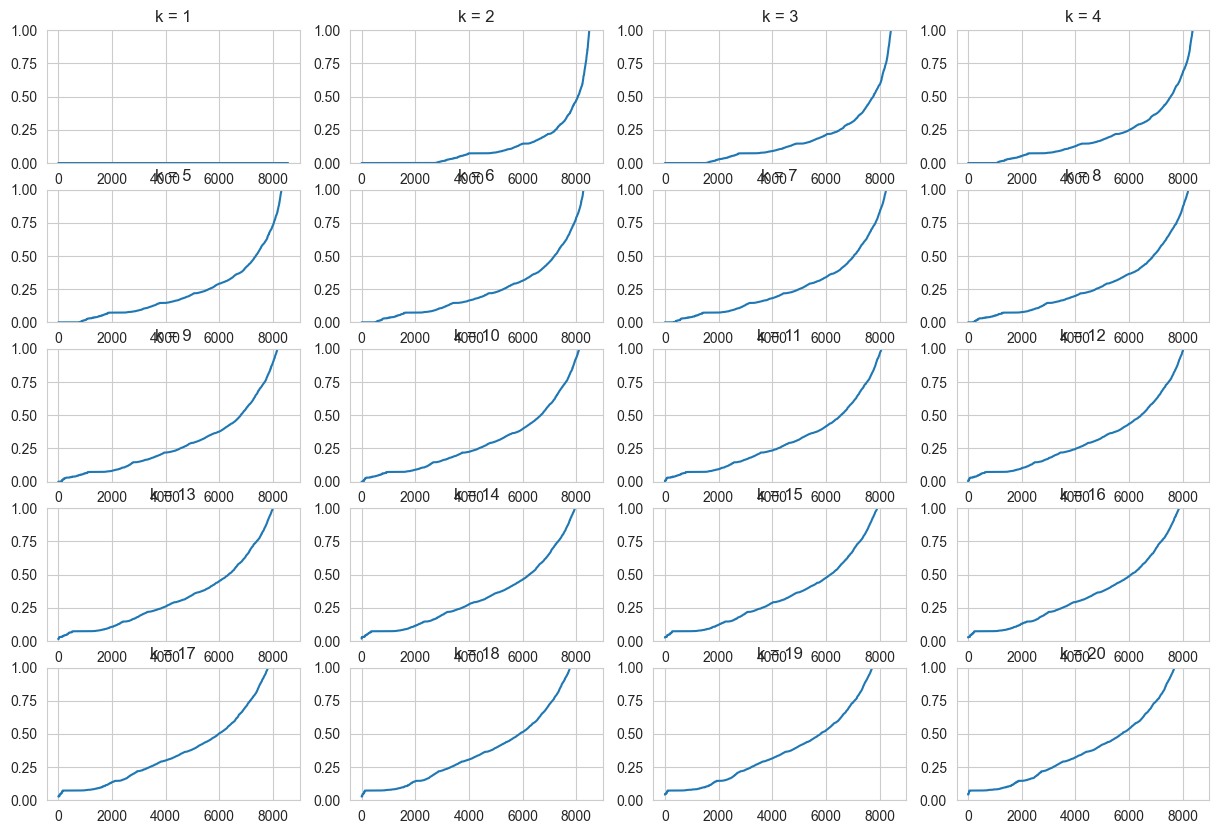

In [69]:
max_k = 20
nbrs = NearestNeighbors(n_neighbors=max_k).fit(df_fl_scaled)
fig , ax = plt.subplots(5, 4, figsize=(15,10))
for k in range(max_k):
    distances, indices = nbrs.kneighbors(df_fl_scaled)
    distances = np.sort(distances, axis=0)
    distances = distances[:,k]
    ax[k//4, k%4].plot(distances)
    ax[k//4, k%4].set_title('k = {}'.format(k+1))
    ax[k//4, k%4].set_ylim([0, 1])

We pick the number of points min_samples=10 and radius eps=0.6 

In [70]:
dbscan= DBSCAN(eps=0.6, min_samples=10).fit(df_fl_scaled)
df_fl['cluster_dbscan'] = dbscan.labels_
df_fl['cluster_dbscan'].value_counts()

C:\Users\HUAWEI\AppData\Local\Temp\ipykernel_32408\2176782065.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fl['cluster_dbscan'] = dbscan.labels_


 0     5298
 1     1065
-1      958
 6      386
 3      210
 2      190
 5      177
 13      38
 4       36
 8       28
 20      19
 12      17
 10      16
 7       15
 18      15
 17      15
 9       14
 11      14
 14      12
 21      11
 19      11
 16       9
 15       7
Name: cluster_dbscan, dtype: int64

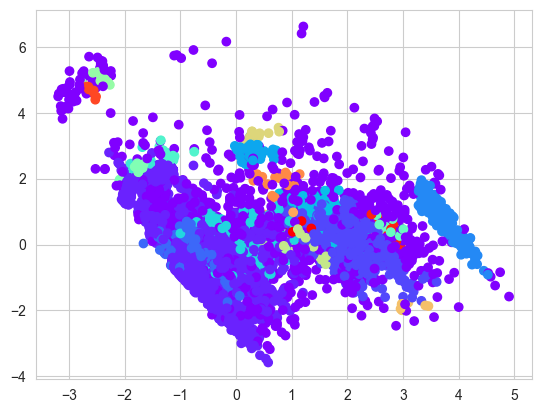

In [71]:
plt.scatter(df_fl_pca[:,0], df_fl_pca[:,1], c=df_fl['cluster_dbscan'], cmap='rainbow')

In [72]:
#plot 3d
pca= PCA(n_components=3)
df_fl_pca = pca.fit_transform(df_fl_scaled)

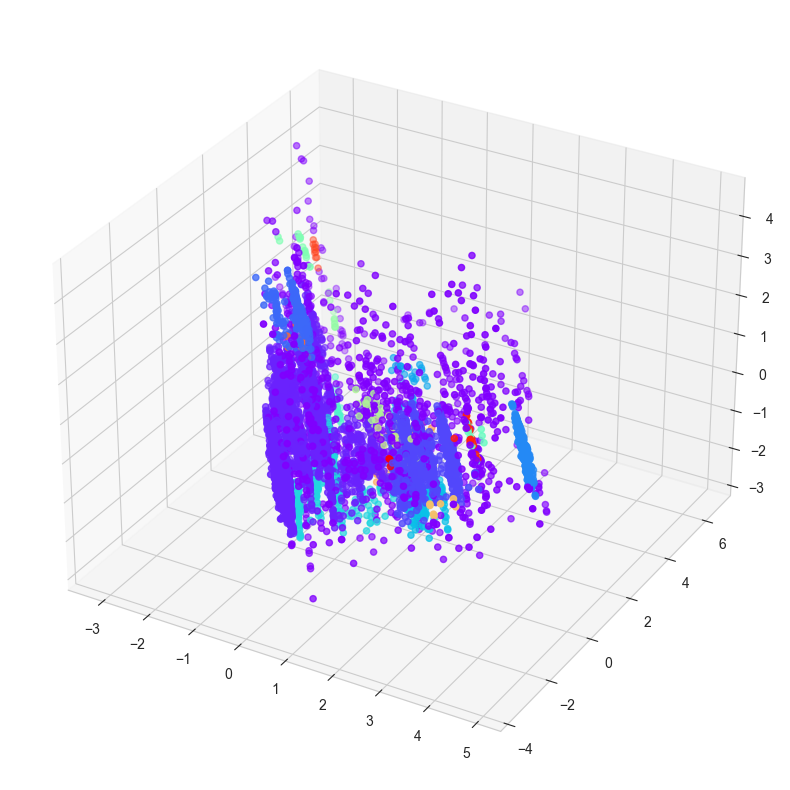

In [73]:

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_fl_pca[:,0], df_fl_pca[:,1], df_fl_pca[:,2], c=df_fl['cluster_dbscan'], cmap='rainbow')

## Hierarchical clustering
We try some linkage methods for Hierarchical clustering (complete, ward, single) on the state of California and then show the clusters on the previous 2-Dimensional PCA plot

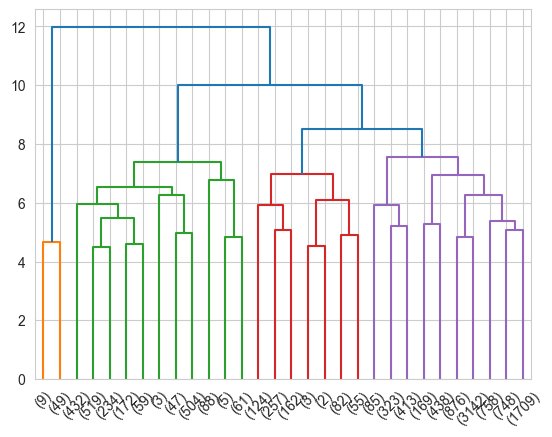

In [74]:
from scipy.stats import mode
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram

data_dist = pdist( df_ca_scaled , metric='euclidean')
data_link = linkage(data_dist, method='complete', metric='euclidean')
res = dendrogram(data_link, truncate_mode='lastp')

In [75]:
from sklearn.cluster import AgglomerativeClustering
aggcluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='complete')
aggcluster.fit_predict(df_ca_scaled)
df_ca['cluster_agg_comp'] = aggcluster.labels_
df_ca['cluster_agg_comp'].value_counts()

C:\Users\HUAWEI\AppData\Local\Temp\ipykernel_32408\4111543711.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ca['cluster_agg_comp'] = aggcluster.labels_


0    8661
2    2124
1     685
3      58
Name: cluster_agg_comp, dtype: int64

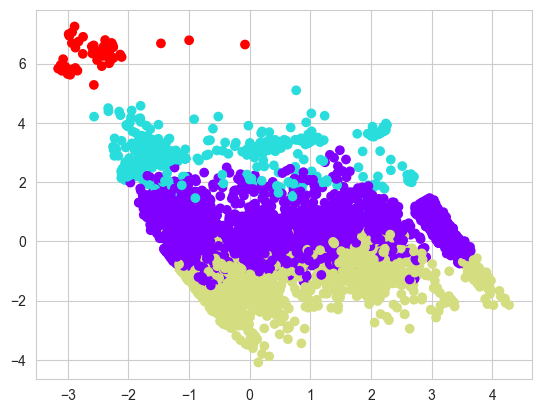

In [76]:
plt.scatter(df_ca_pca[:,0], df_ca_pca[:,1], c=df_ca['cluster_agg_comp'], cmap='rainbow')

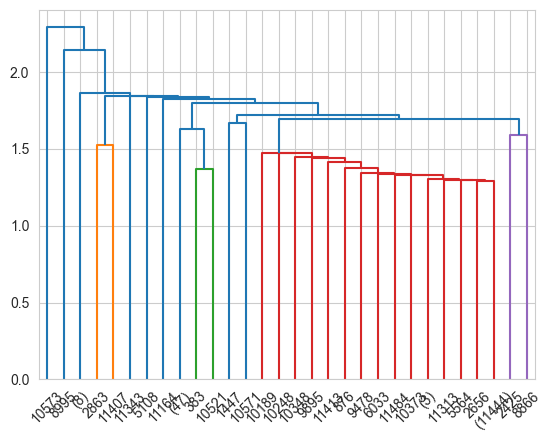

In [77]:
data_dist = pdist( df_ca_scaled , metric='euclidean')
data_link = linkage(data_dist, method='single', metric='euclidean')
res = dendrogram(data_link, truncate_mode='lastp')

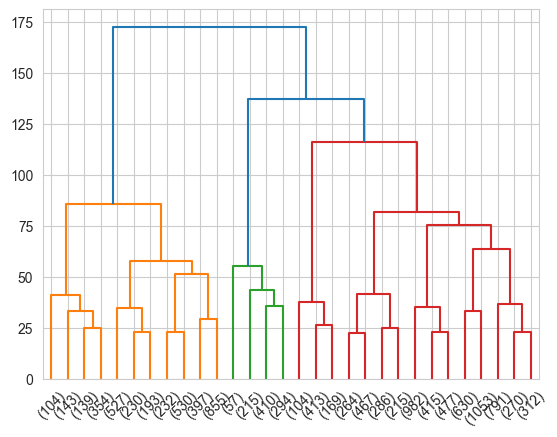

In [78]:
data_dist = pdist( df_ca_scaled , metric='euclidean')
data_link = linkage(data_dist, method='ward', metric='euclidean')
res = dendrogram(data_link, truncate_mode='lastp')

from the dendrogram, we can see that the red cluster can be splitted in two clusters, so we can try to use 4 clusters.

In [79]:
aggcluster_ward = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')
aggcluster_ward.fit_predict(df_ca_scaled)
df_ca['cluster_agg_ward'] = aggcluster_ward.labels_
df_ca['cluster_agg_ward'].value_counts()

C:\Users\HUAWEI\AppData\Local\Temp\ipykernel_32408\3969782099.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ca['cluster_agg_ward'] = aggcluster_ward.labels_


1    6162
0    3704
2     976
3     686
Name: cluster_agg_ward, dtype: int64

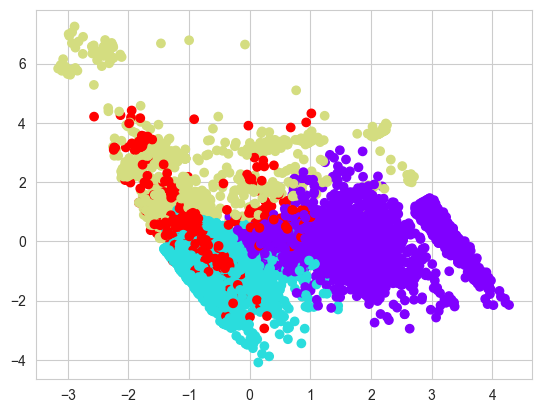

In [80]:
plt.scatter(df_ca_pca[:,0], df_ca_pca[:,1], c=df_ca['cluster_agg_ward'], cmap='rainbow')

In [81]:
#todo ran kmeans on the clusters obtained with hierarchical clustering

## Cluster validation
TODO